# Task 3: Cuisine Classification
Utilizing restaurant data, this task focuses on developing a machine learning model to classify restaurants based on their cuisines.

For this task I will use `random forest`  because it is very good when dealing with mixed datatypes, handles non-linearity and feature interactions well and can resistant to overfitting with proper tuning.

In [98]:
# Import some libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
# Load the data
data = pd.read_csv('D:/Cognifyz internship/Dataset_Cog_int.csv')
data.head()

Restaurant ID         Restaurant Name  Country Code              City  \
0        6317637        Le Petit Souffle           162       Makati City   
1        6304287        Izakaya Kikufuji           162       Makati City   
2        6300002  Heat - Edsa Shangri-La           162  Mandaluyong City   
3        6318506                    Ooma           162  Mandaluyong City   
4        6314302             Sambo Kojin           162  Mandaluyong City   

                                             Address  \
0  Third Floor, Century City Mall, Kalayaan Avenu...   
1  Little Tokyo, 2277 Chino Roces Avenue, Legaspi...   
2  Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...   
3  Third Floor, Mega Fashion Hall, SM Megamall, O...   
4  Third Floor, Mega Atrium, SM Megamall, Ortigas...   

                                     Locality  \
0   Century City Mall, Poblacion, Makati City   
1  Little Tokyo, Legaspi Village, Makati City   
2  Edsa Shangri-La, Ortigas, Mandaluyong City   
3      SM Megamall, Ortigas, Mandaluyong City   
4      SM Megamall, Ortigas, Mandaluyong City   

                                    Locality Verbose   Longitude   Latitude  \
0  Century City Mall, Poblacion, Makati City, Mak...  121.027535  14.565443   
1  Little Tokyo, Legaspi Village, Makati City, Ma...  121.014101  14.553708   
2  Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...  121.056831  14.581404   
3  SM Megamall, Ortigas, Mandaluyong City, Mandal...  121.056475  14.585318   
4  SM Megamall, Ortigas, Mandaluyong City, Mandal...  121.057508  14.584450   

                           Cuisines  ...          Currency Has Table booking  \
0        French, Japanese, Desserts  ...  Botswana Pula(P)               Yes   
1                          Japanese  ...  Botswana Pula(P)               Yes   
2  Seafood, Asian, Filipino, Indian  ...  Botswana Pula(P)               Yes   
3                   Japanese, Sushi  ...  Botswana Pula(P)                No   
4                  Japanese, Korean  ...  Botswana Pula(P)               Yes   

  Has Online delivery Is delivering now Switch to order menu Price range  \
0                  No                No                   No           3   
1                  No                No                   No           3   
2                  No                No                   No           4   
3                  No                No                   No           4   
4                  No                No                   No           4   

   Aggregate rating  Rating color Rating text Votes  
0               4.8    Dark Green   Excellent   314  
1               4.5    Dark Green   Excellent   591  
2               4.4         Green   Very Good   270  
3               4.9    Dark Green   Excellent   365  
4               4.8    Dark Green   Excellent   229  

[5 rows x 21 columns]

In [100]:
# Checking missing values
print(data.isnull().sum())
print(f"shape of the data is: {data.shape}")

Restaurant ID           0
Restaurant Name         0
Country Code            0
City                    0
Address                 0
Locality                0
Locality Verbose        0
Longitude               0
Latitude                0
Cuisines                9
Average Cost for two    0
Currency                0
Has Table booking       0
Has Online delivery     0
Is delivering now       0
Switch to order menu    0
Price range             0
Aggregate rating        0
Rating color            0
Rating text             0
Votes                   0
dtype: int64
shape of the data is: (9551, 21)


In [101]:
# null values
print(f"Number of rows with Cuisine null values is: {data['Cuisines'].isnull().sum()}")

Number of rows with Cuisine null values is: 9


In [104]:
# dropping missing values

clean_data = data.dropna(subset=['Cuisines'])
clean_data = clean_data.reset_index(drop=True)
print(f"shape after removing null values: {clean_data.shape}")

shape after removing null values: (9542, 21)


Since it's multi-label, I will use MultiOutputClassifier with RandomForest

In [105]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9542 entries, 0 to 9541
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant ID         9542 non-null   int64  
 1   Restaurant Name       9542 non-null   object 
 2   Country Code          9542 non-null   int64  
 3   City                  9542 non-null   object 
 4   Address               9542 non-null   object 
 5   Locality              9542 non-null   object 
 6   Locality Verbose      9542 non-null   object 
 7   Longitude             9542 non-null   float64
 8   Latitude              9542 non-null   float64
 9   Cuisines              9542 non-null   object 
 10  Average Cost for two  9542 non-null   int64  
 11  Currency              9542 non-null   object 
 12  Has Table booking     9542 non-null   object 
 13  Has Online delivery   9542 non-null   object 
 14  Is delivering now     9542 non-null   object 
 15  Switch to order menu 

In [106]:
# encoding categorical variables
clean_data = pd.get_dummies(clean_data, columns=['City', 'Has Table booking', 'Has Online delivery', 'Is delivering now', 'Switch to order menu'], drop_first=True)

# Split cuisines into lists for multi-label encoding
clean_data['Cuisines'] = clean_data['Cuisines'].str.split(', ')

# Use MultiLabelBinarizer to encode cuisines
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
cuisines_encoded = mlb.fit_transform(clean_data['Cuisines'])
cuisines_df = pd.DataFrame(cuisines_encoded, columns=mlb.classes_)

# Concatenate the encoded cuisines back to the original dataframe
clean_data = pd.concat([clean_data, cuisines_df], axis=1)

In [107]:
X = clean_data.drop(columns=['Cuisines', 'Restaurant ID', 'Restaurant Name', 'Currency', 'Address', 'Locality', 'Locality Verbose', 'Rating color', 'Rating text', 'Votes'])
y = cuisines_df

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

model = MultiOutputClassifier(RandomForestClassifier(random_state=42))
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [111]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=mlb.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

Accuracy: 0.9188056574122577
Classification Report:
                    precision    recall  f1-score   support

          Afghani       0.00      0.00      0.00         4
          African       0.00      0.00      0.00         3
         American       1.00      1.00      1.00        73
           Andhra       0.00      0.00      0.00         2
          Arabian       1.00      1.00      1.00         2
        Argentine       0.00      0.00      0.00         1
         Armenian       0.00      0.00      0.00         0
            Asian       1.00      1.00      1.00        50
     Asian Fusion       0.00      0.00      0.00         1
         Assamese       0.00      0.00      0.00         0
       Australian       0.00      0.00      0.00         1
           Awadhi       0.00      0.00      0.00         0
              BBQ       1.00      0.62      0.77         8
           Bakery       1.00      0.96      0.98       135
         Bar Food       1.00      0.46      0.63        13
  

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sk

My classification model present quite good accuracy of **91.88%**.  
The warnings I am receiving indicate that there are some classes (cuisines) in the dataset that either have no predicted samples or no true samples in the test set. This situation can arise in multi-label classification, particularly if some cuisines are rare or if the model is not predicting any instances of certain classes.

Here’s how I'll address these issues:

I will Use `class weights` and `zero_division`  Parameters:  
* Because some cuisines are underrepresented, I will use `class weights` in the Random Forest model to give more importance to underrepresented classes.
* When calculating the classification report, I will specify the `zero_division` parameter to control the behavior when there are no predicted samples for a class. Setting zero_division=0 will avoid the warnings and set the precision and recall to 0 for those classes without predictions.  

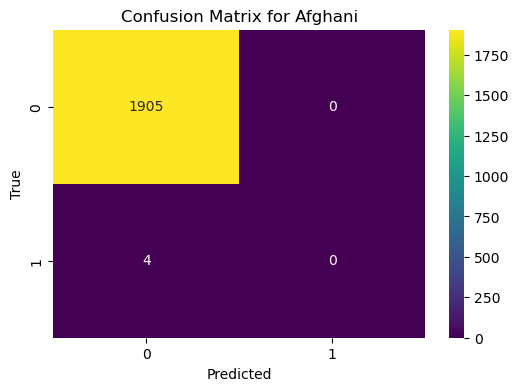

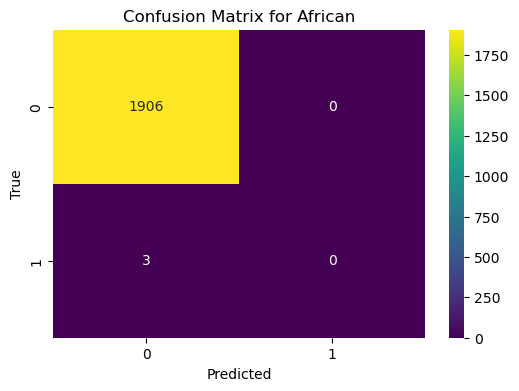

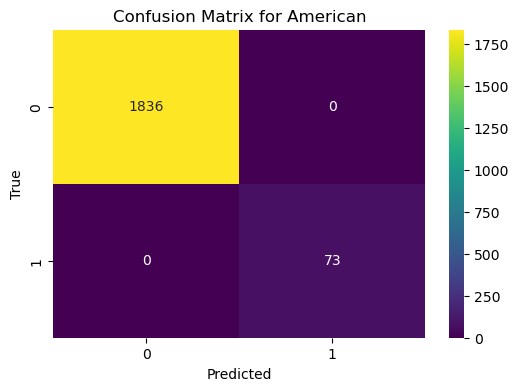

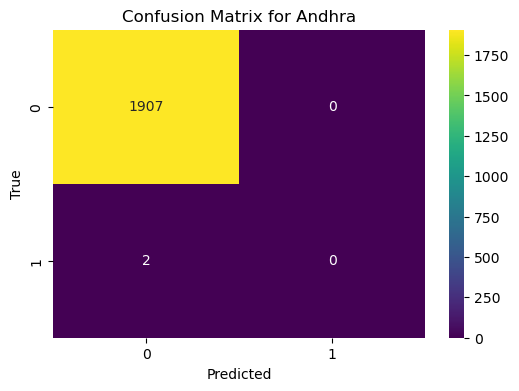

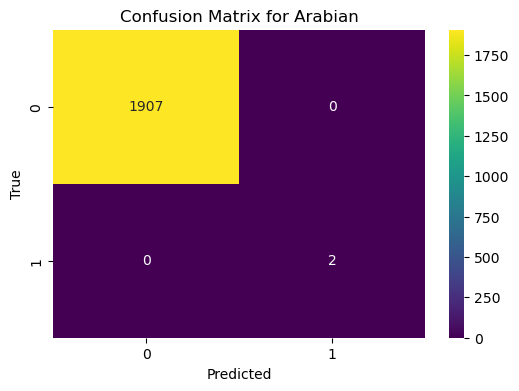

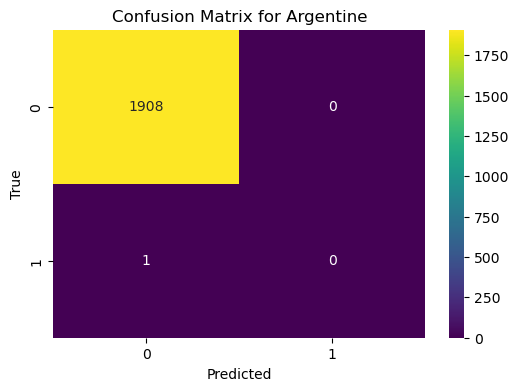

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


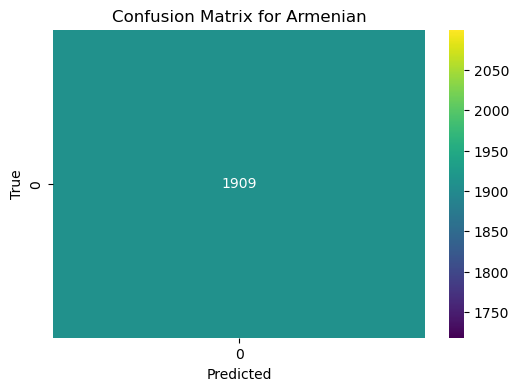

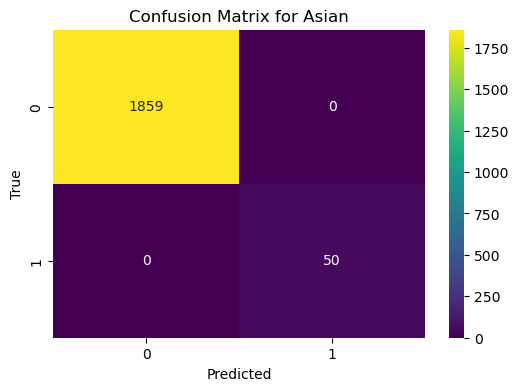

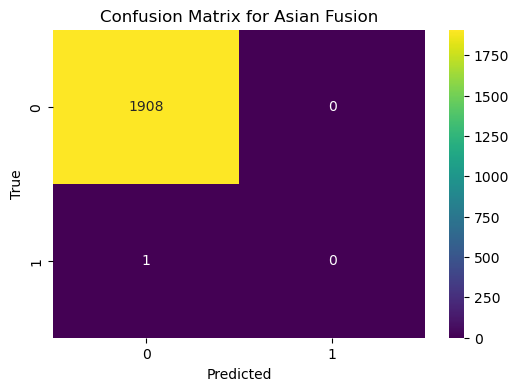

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


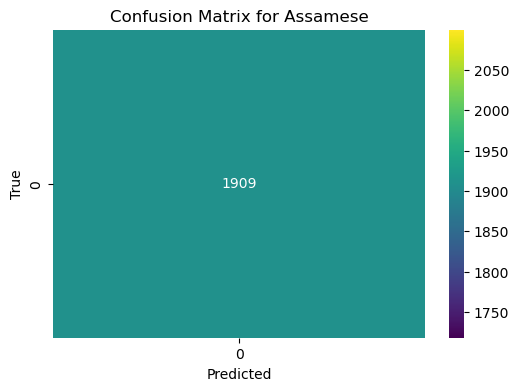

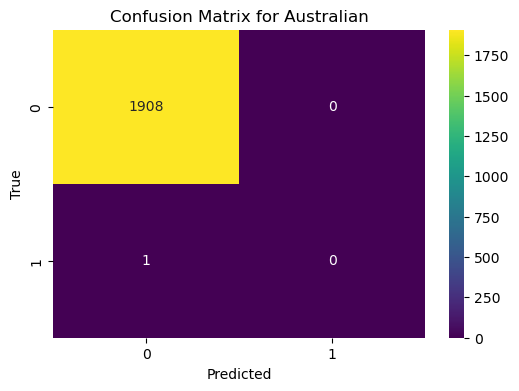

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


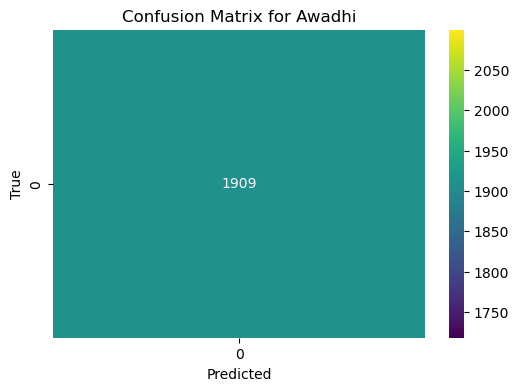

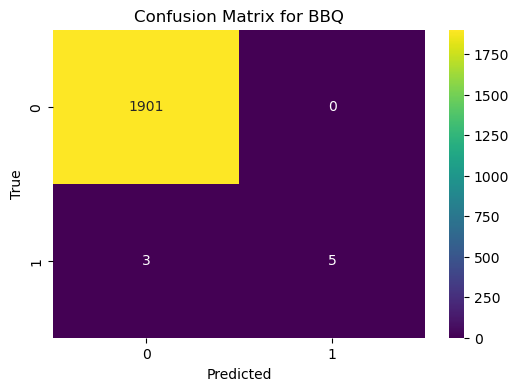

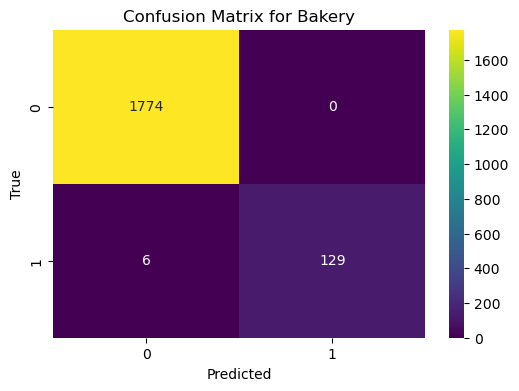

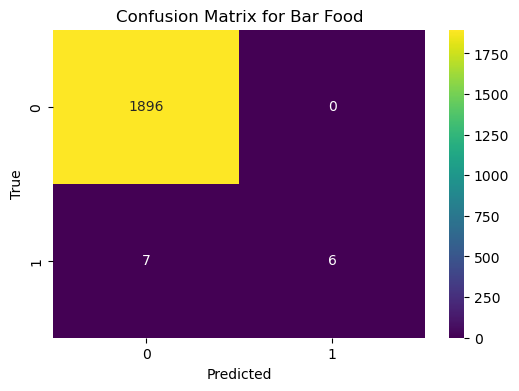

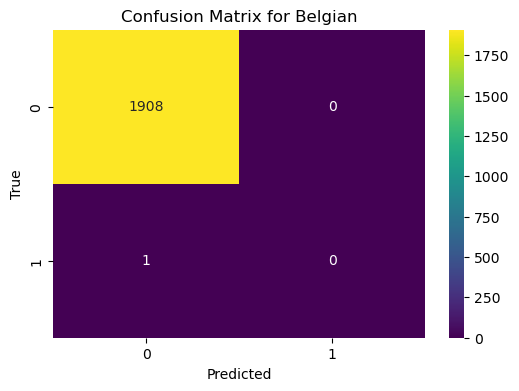

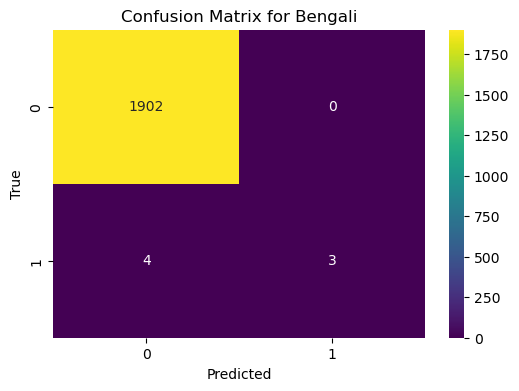

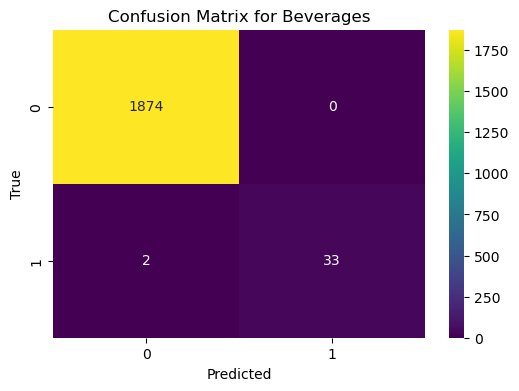

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


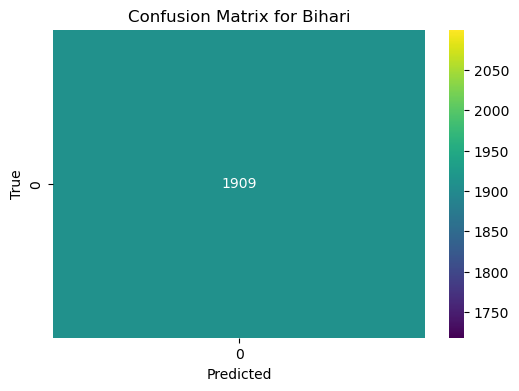

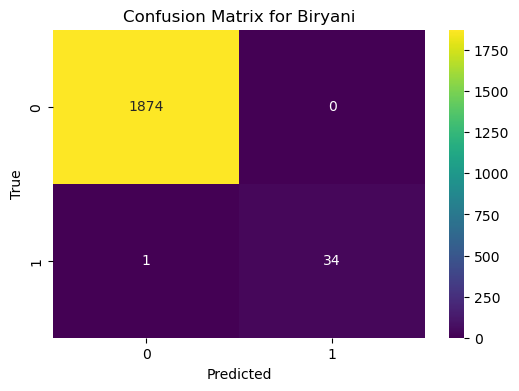

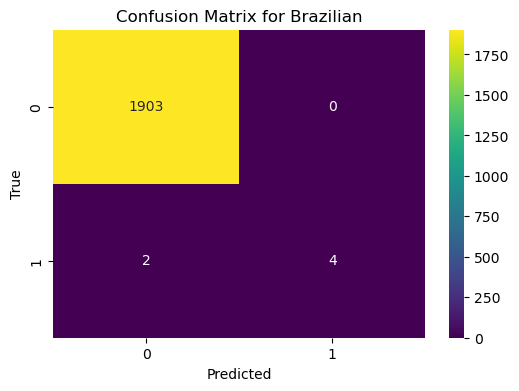

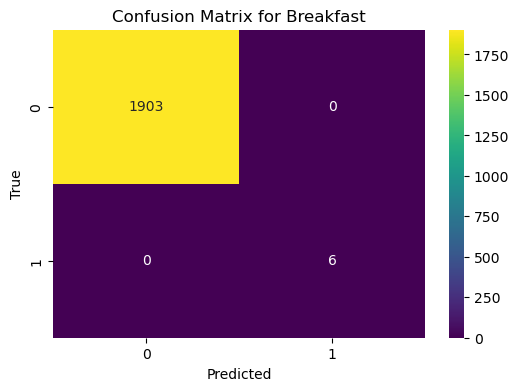

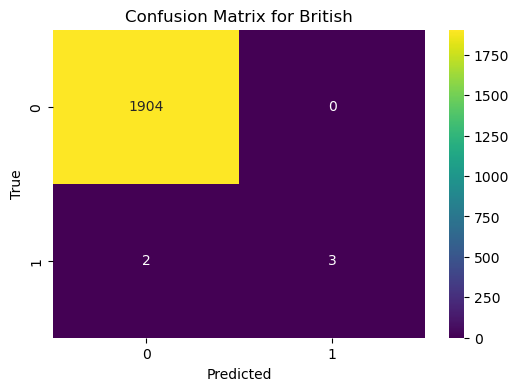

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


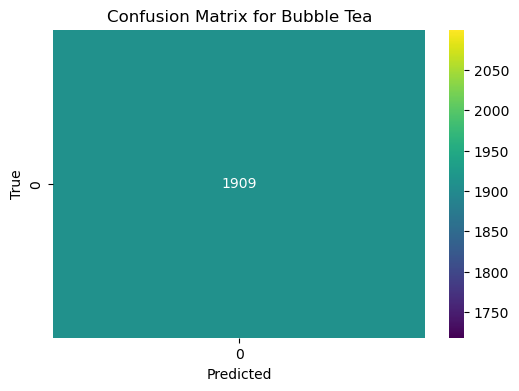

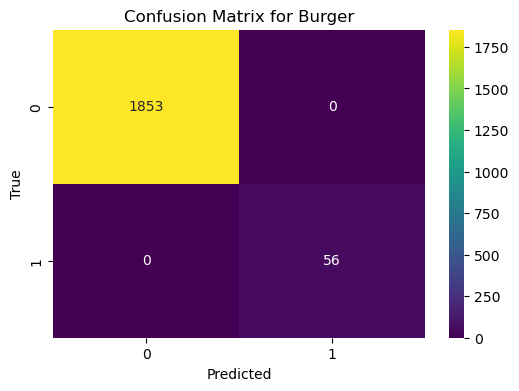

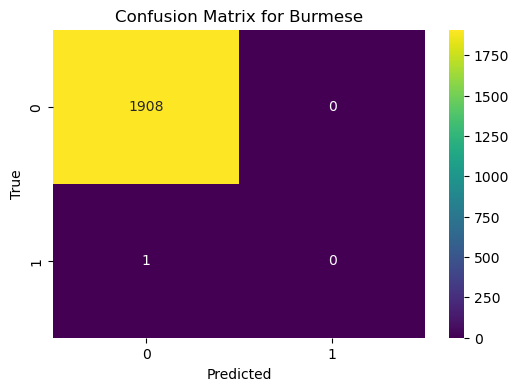

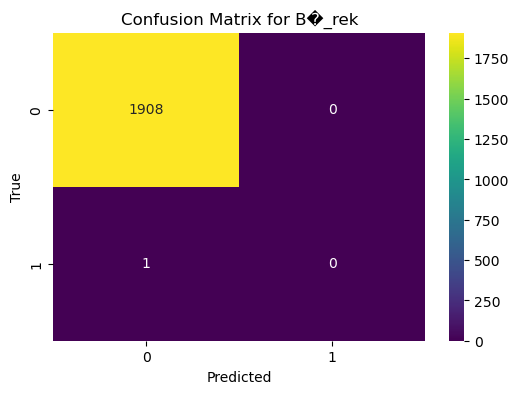

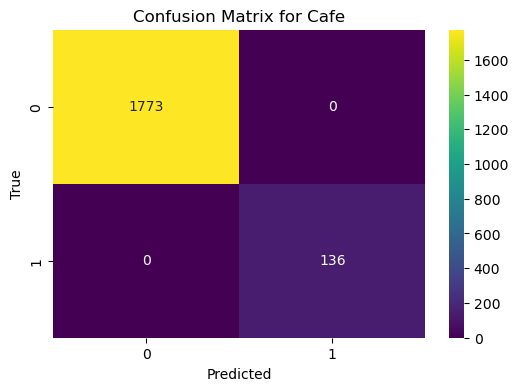

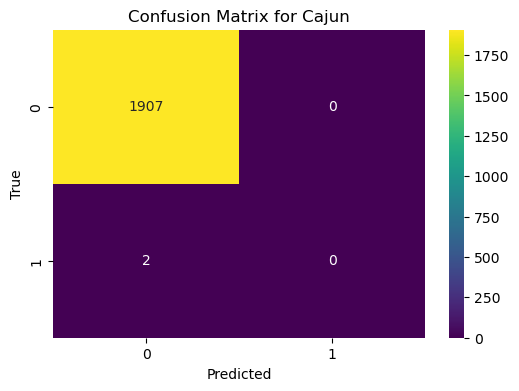

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


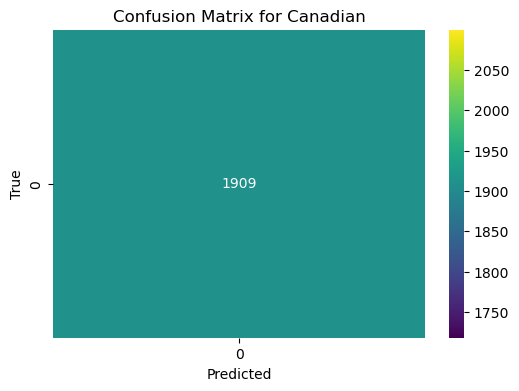

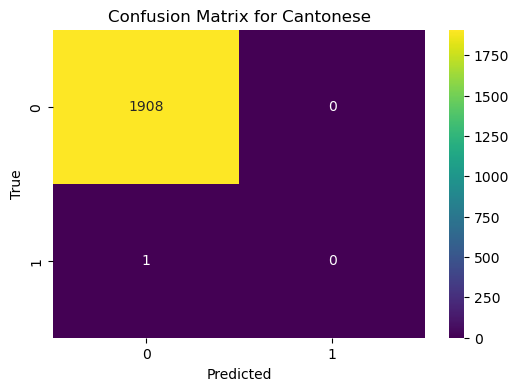

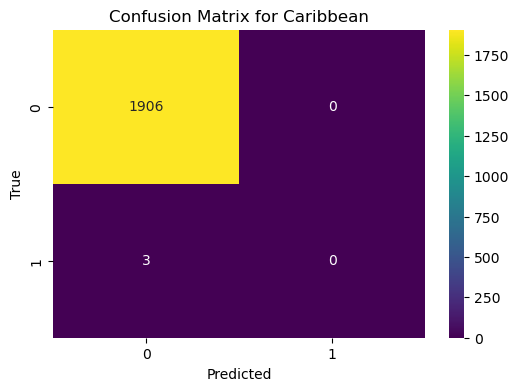

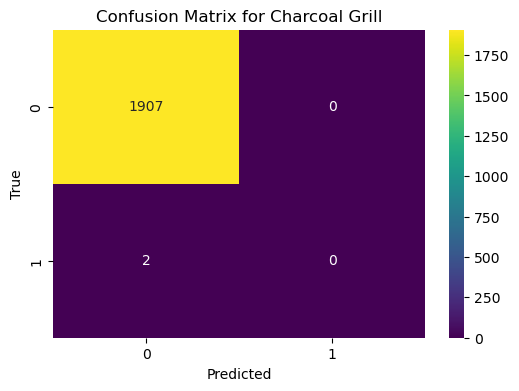

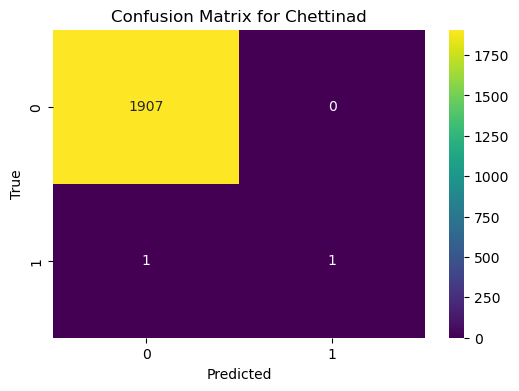

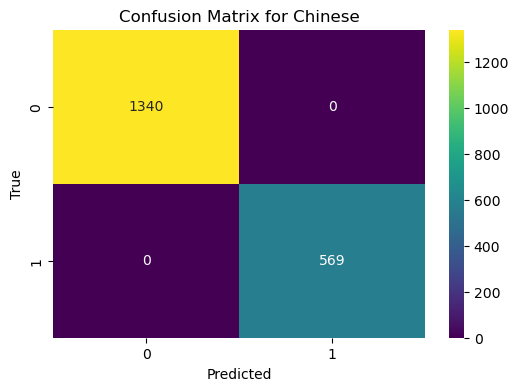

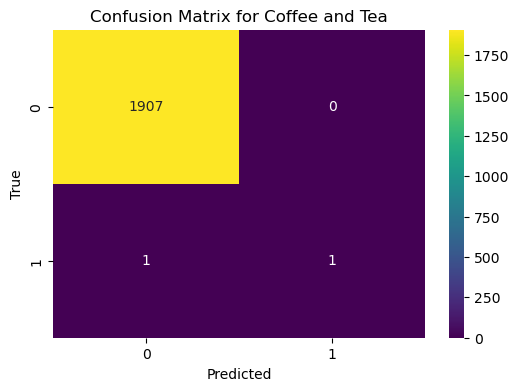

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


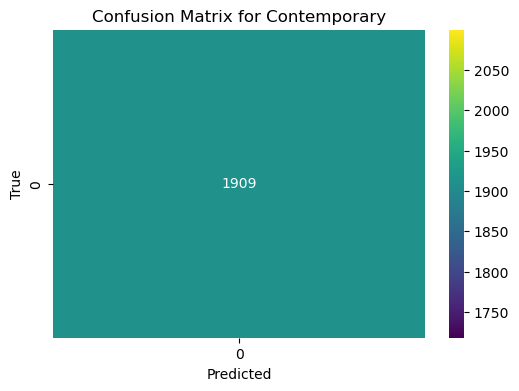

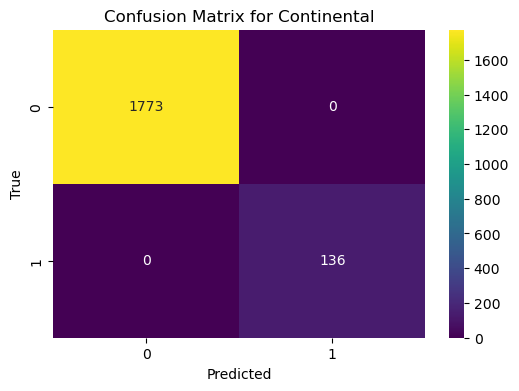

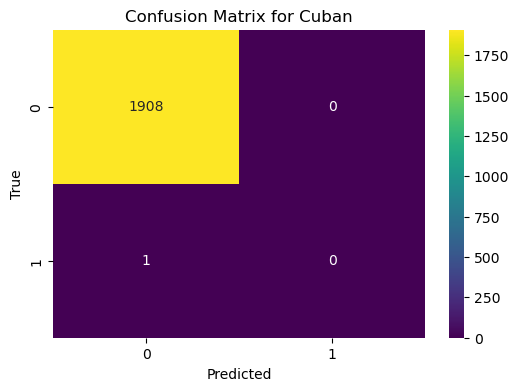

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


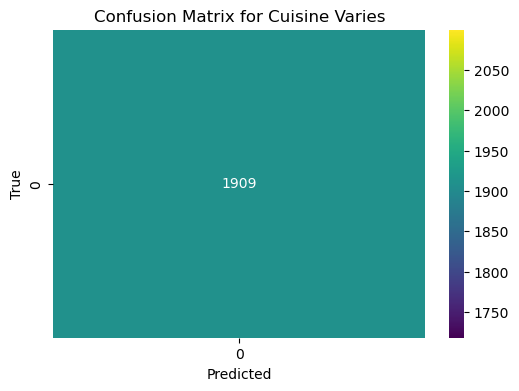

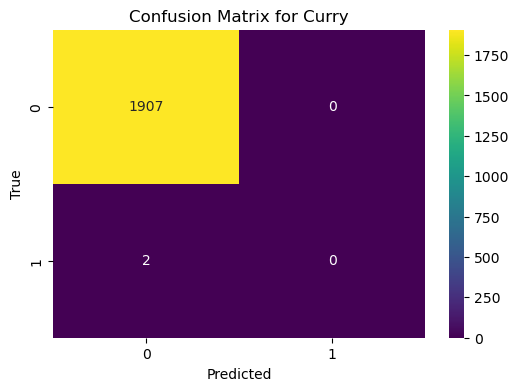

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


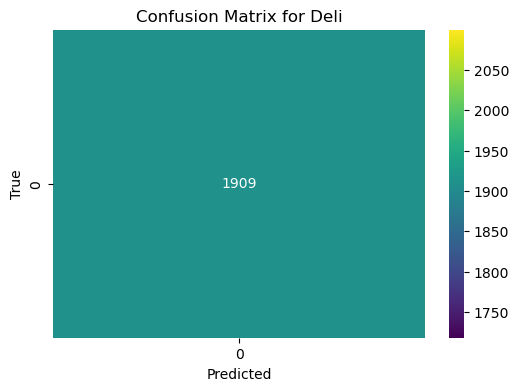

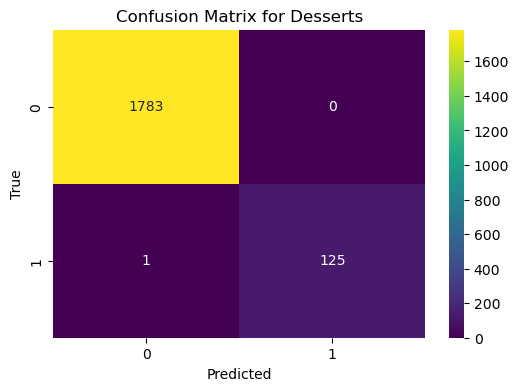

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


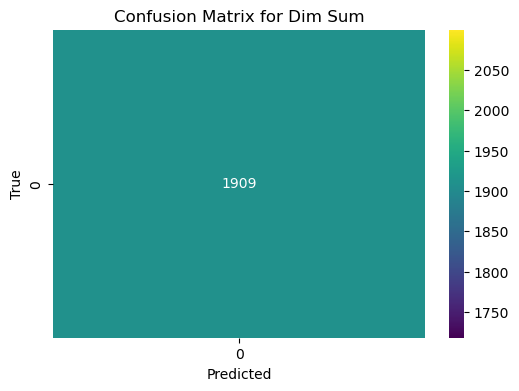

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


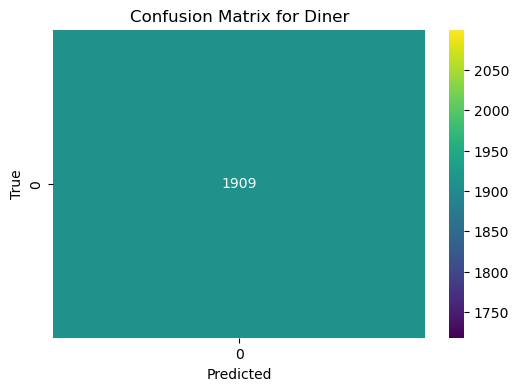

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


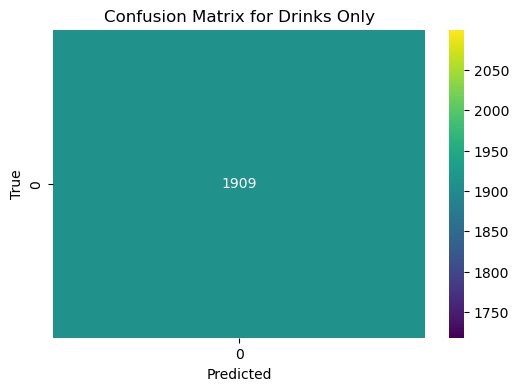

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


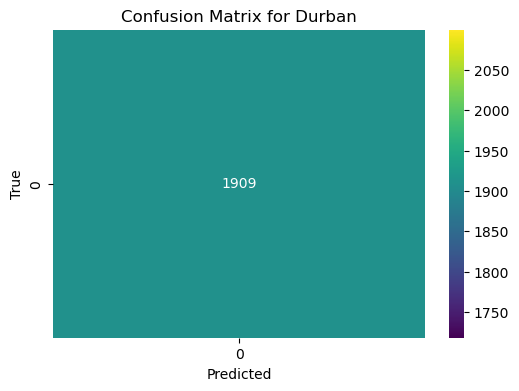

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


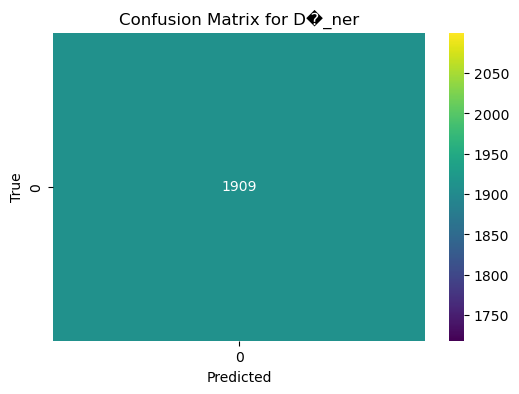

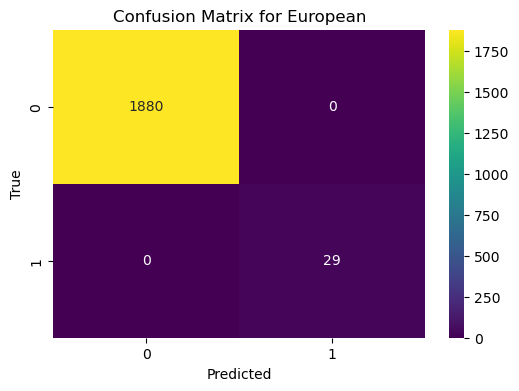

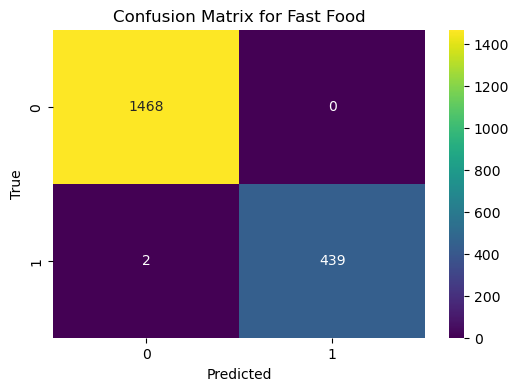

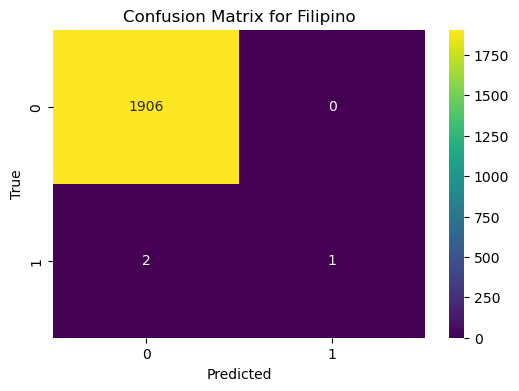

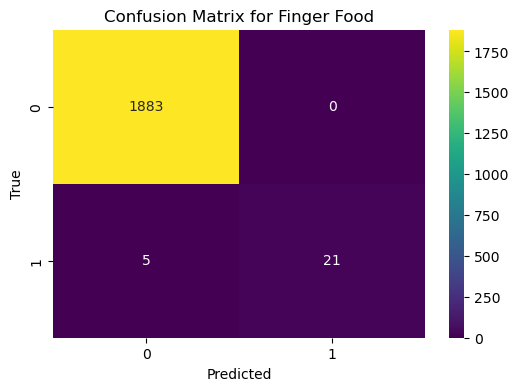

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


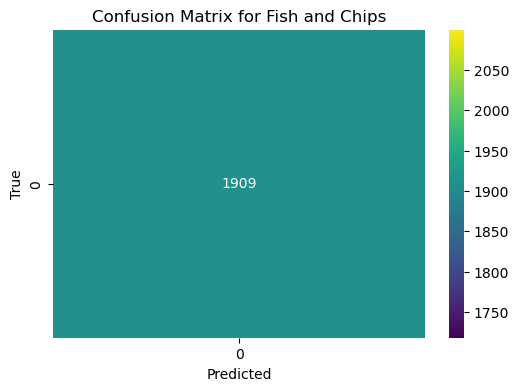

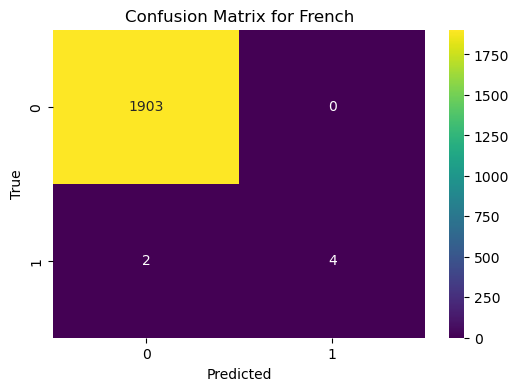

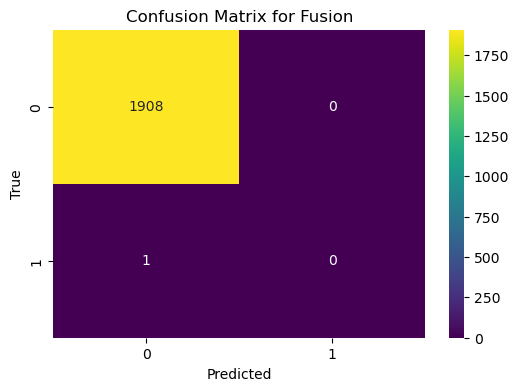

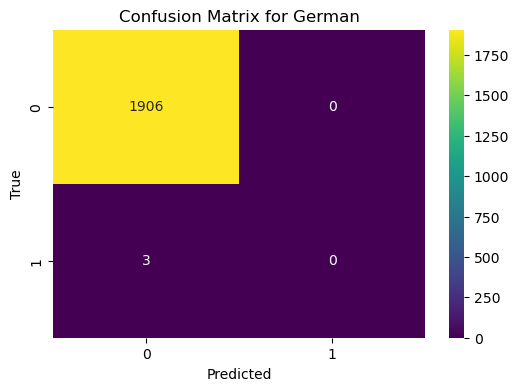

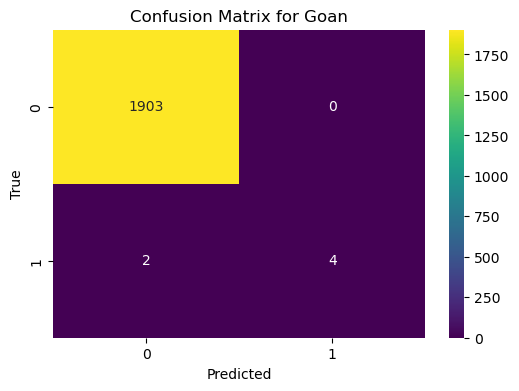

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


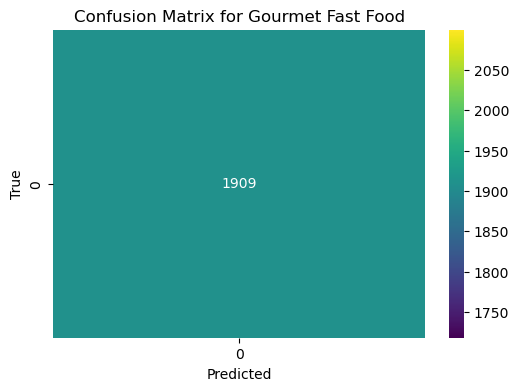

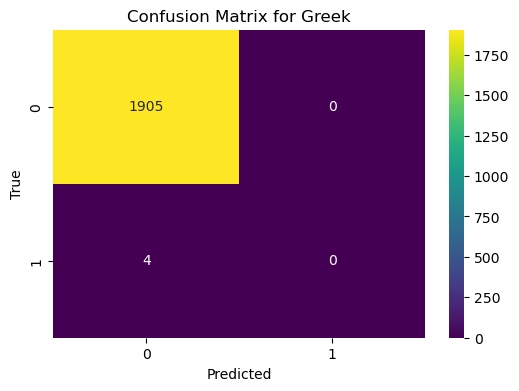

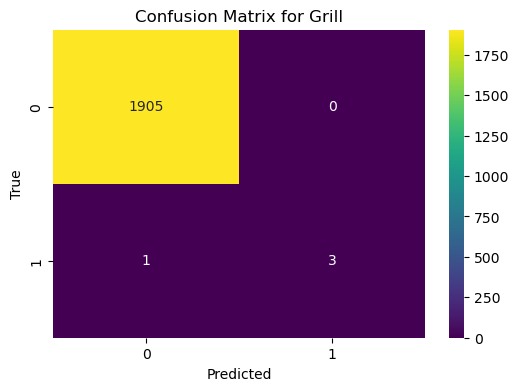

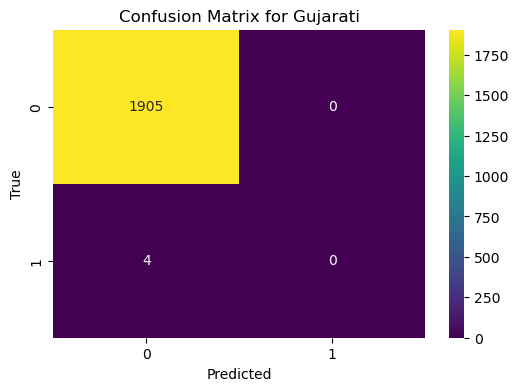

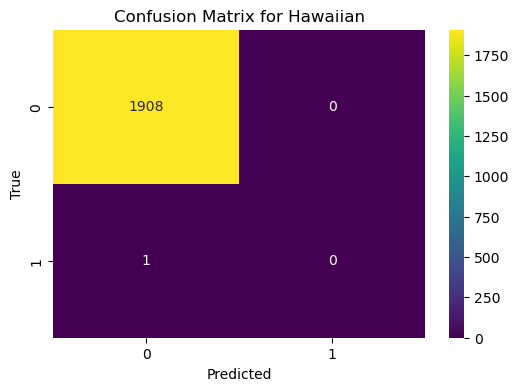

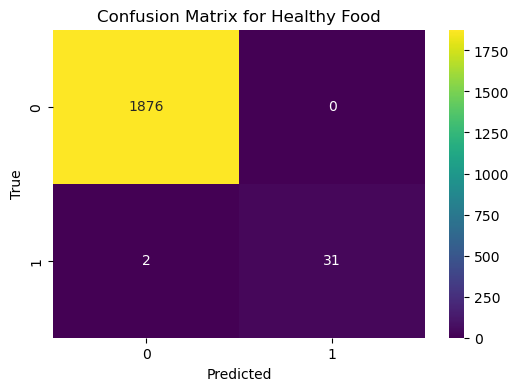

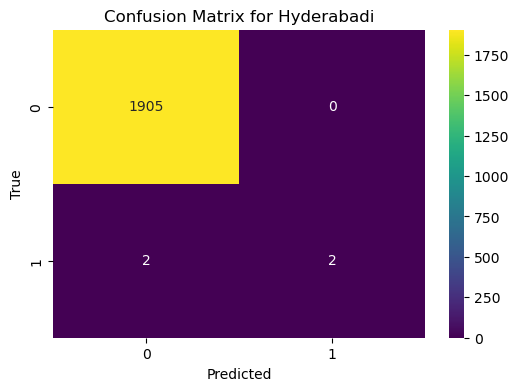

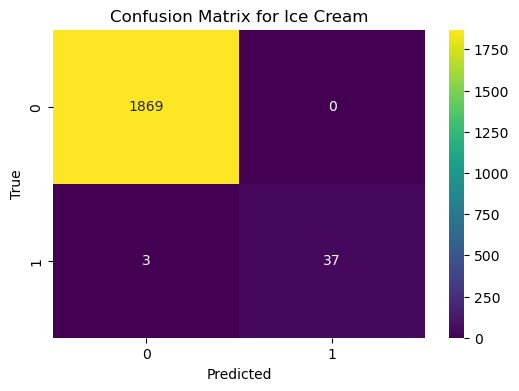

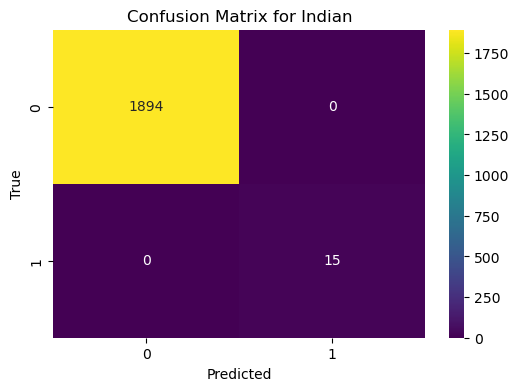

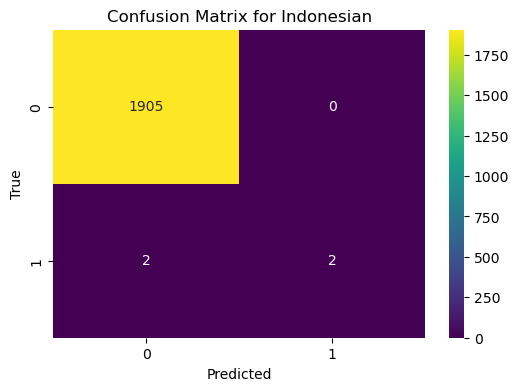

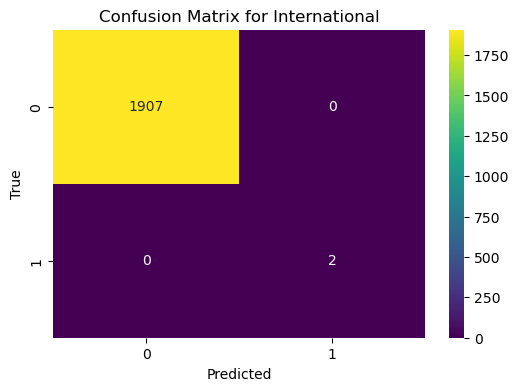

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


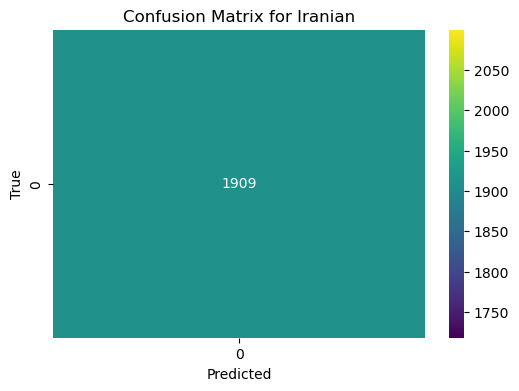

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


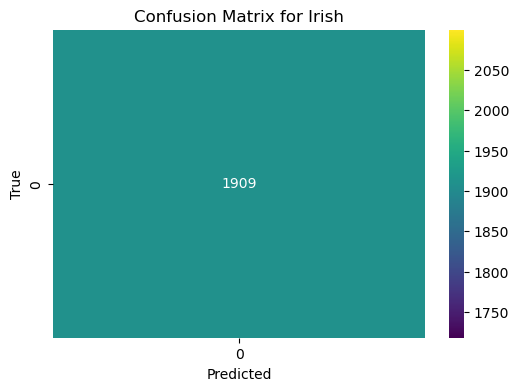

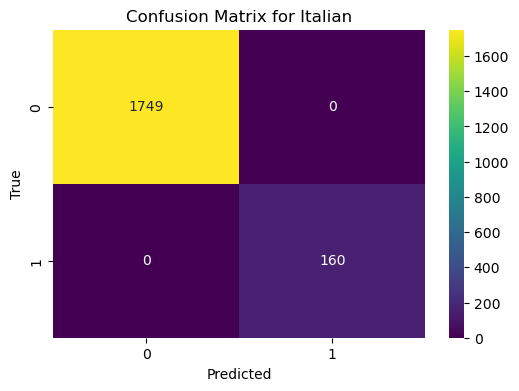

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


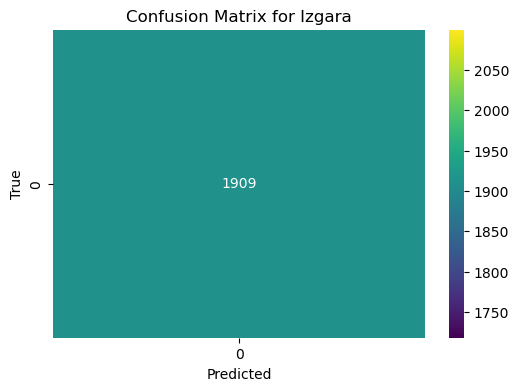

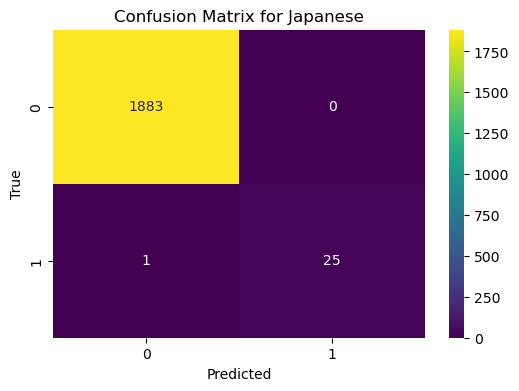

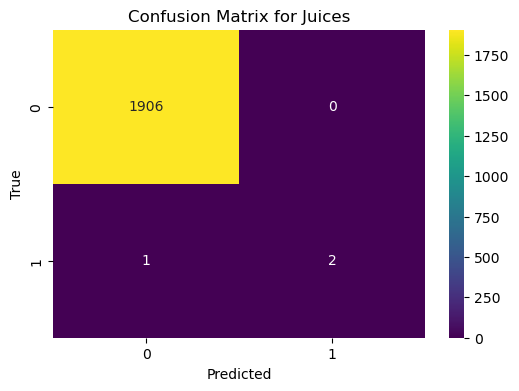

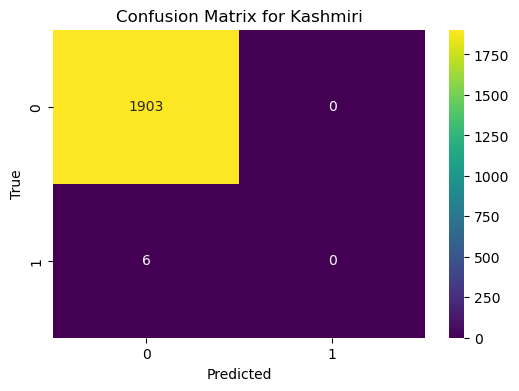

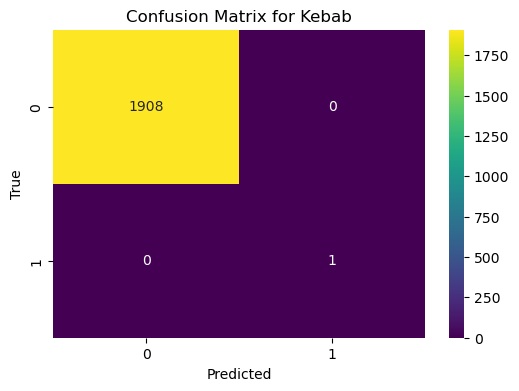

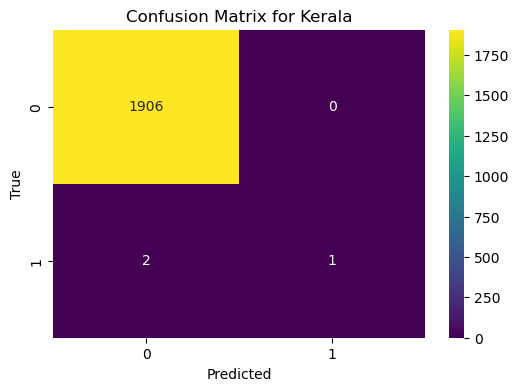

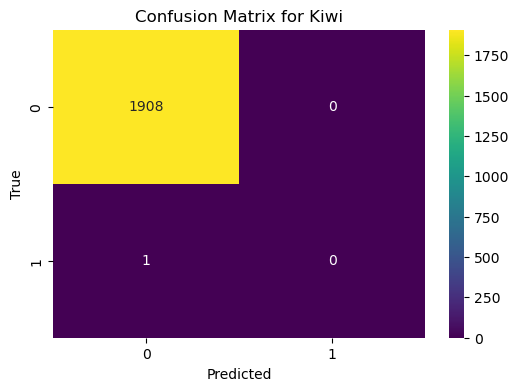

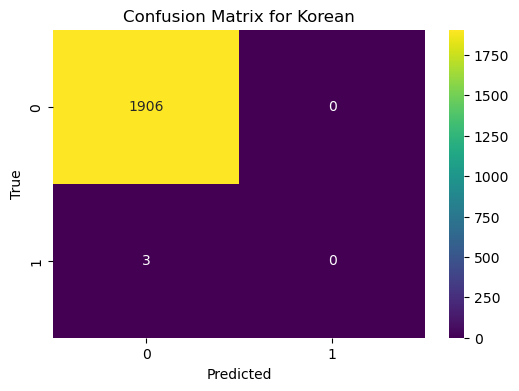

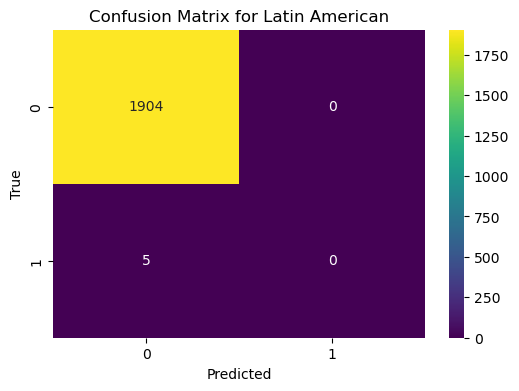

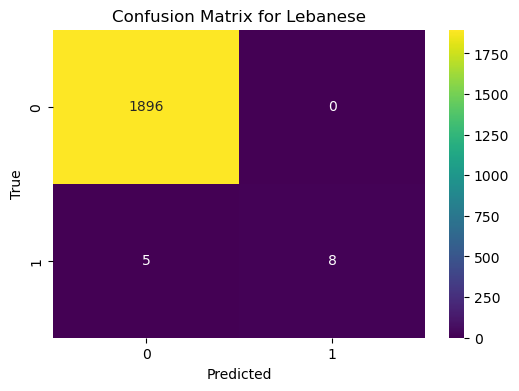

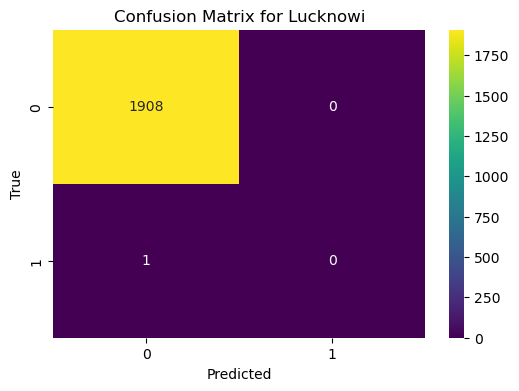

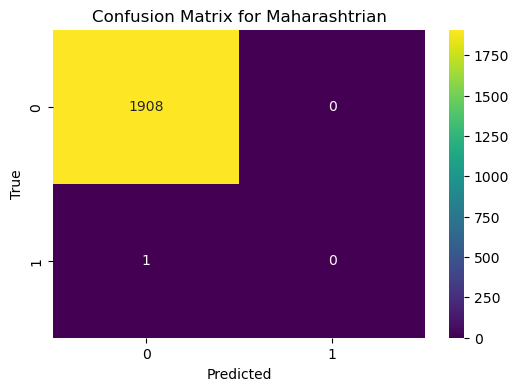

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


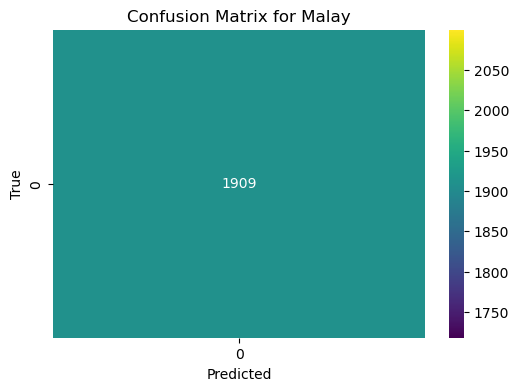

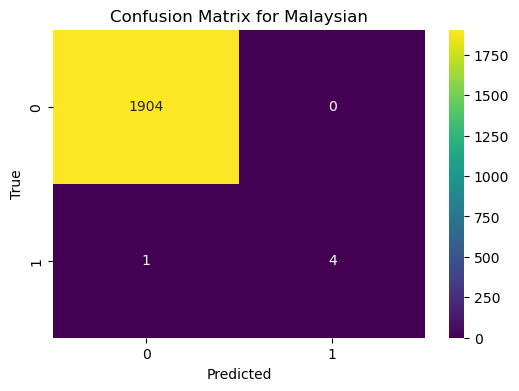

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


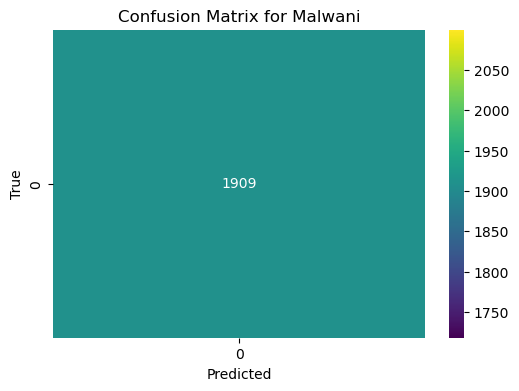

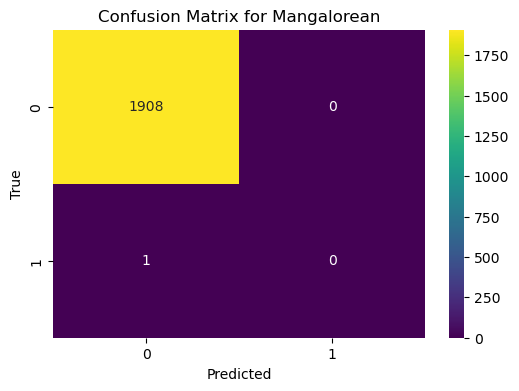

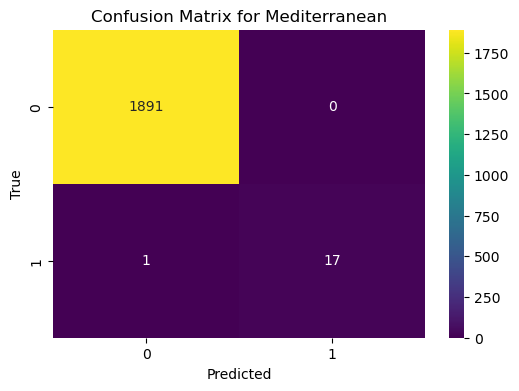

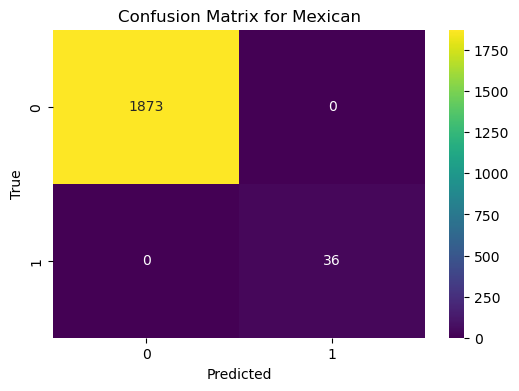

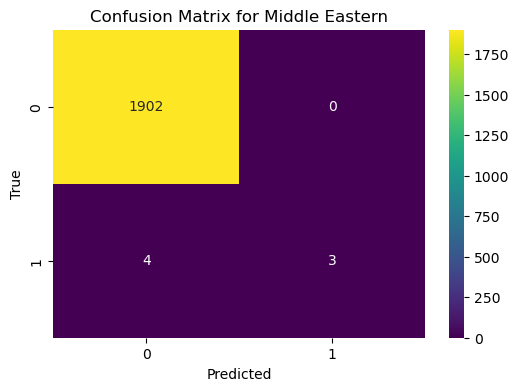

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


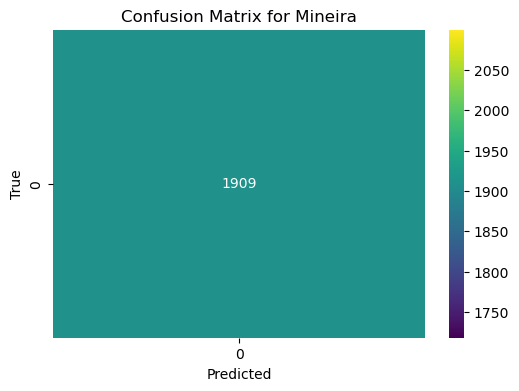

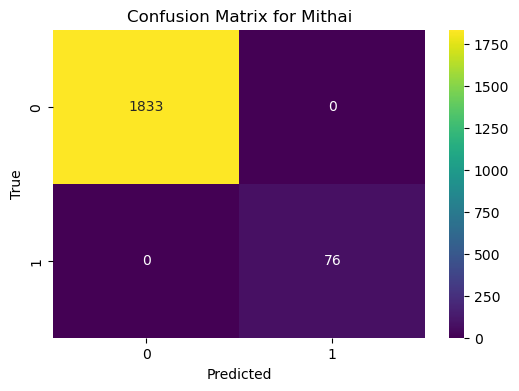

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


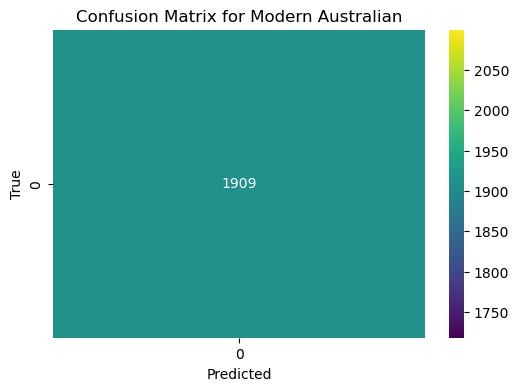

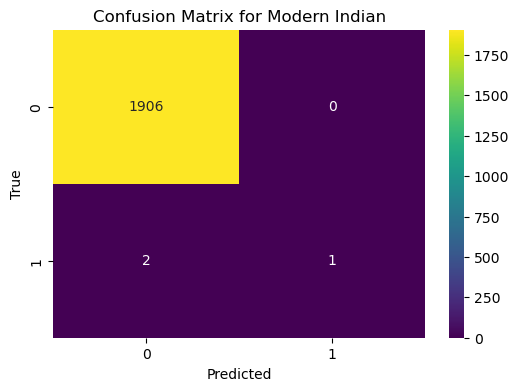

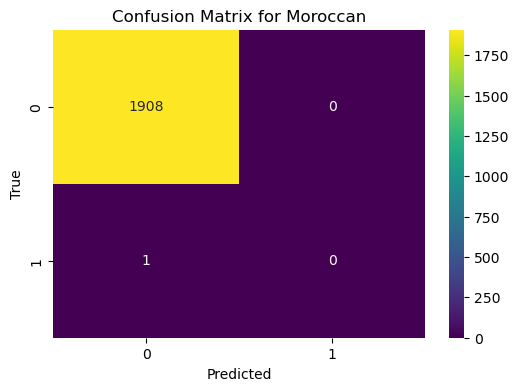

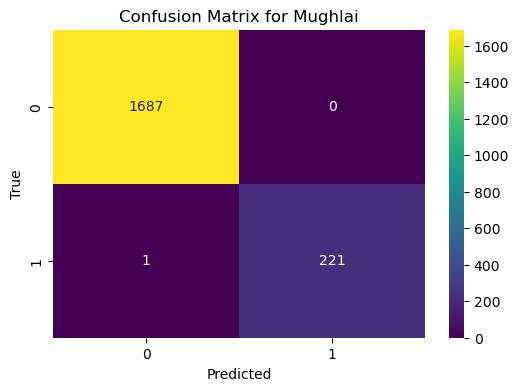

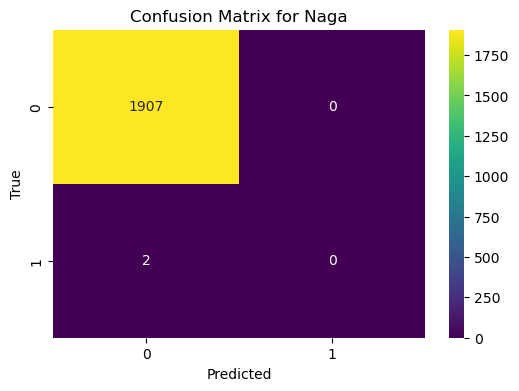

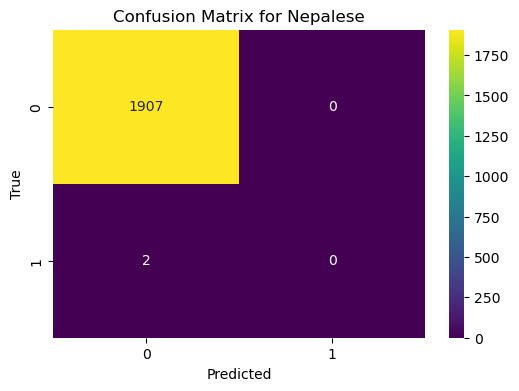

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


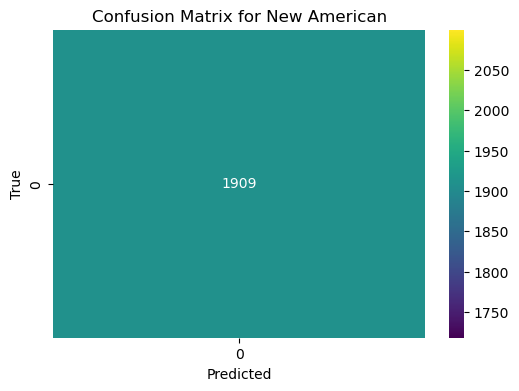

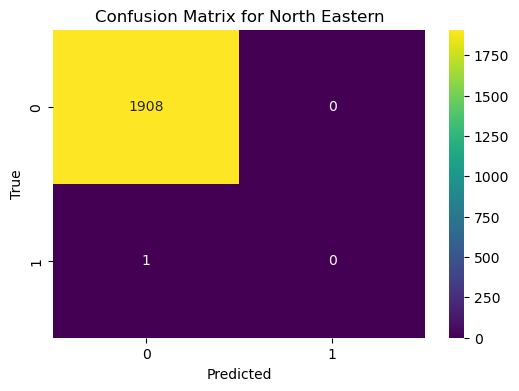

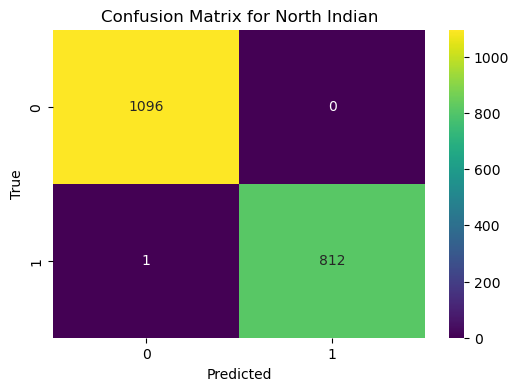

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


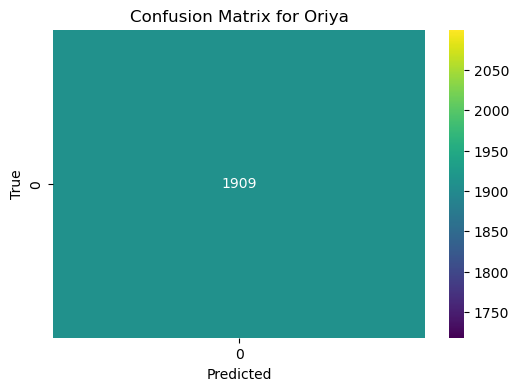

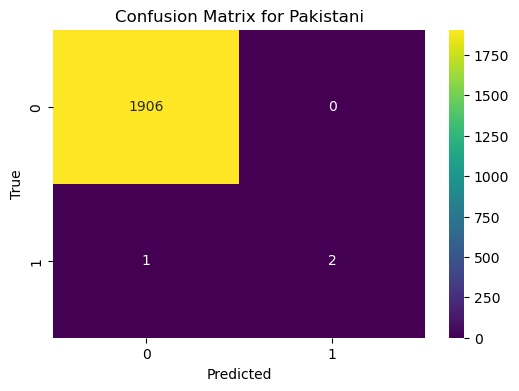

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


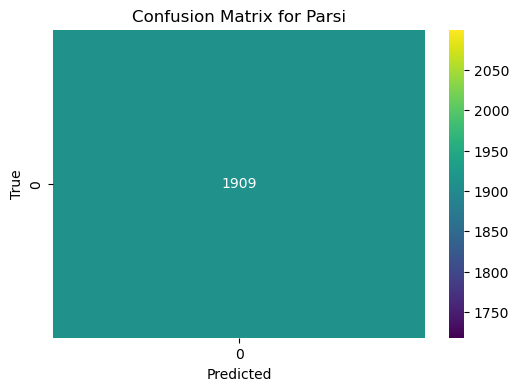

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


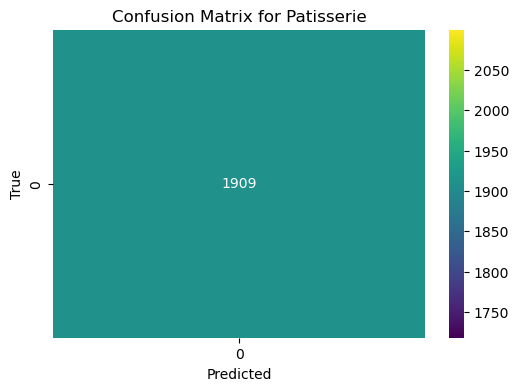

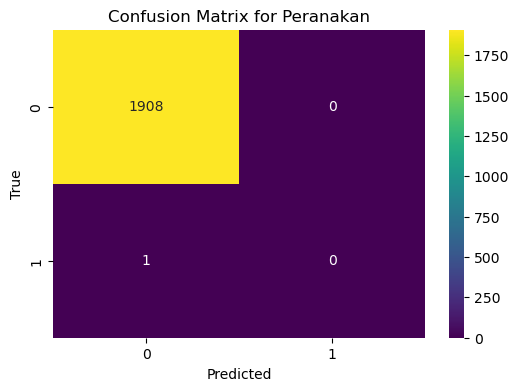

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


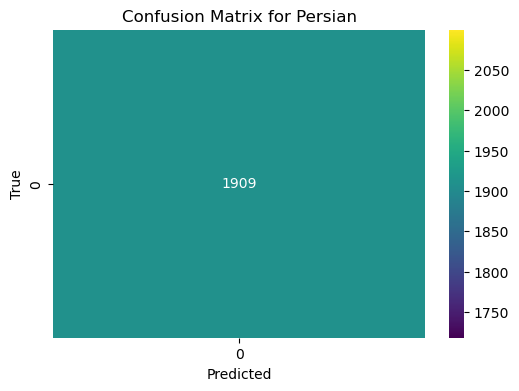

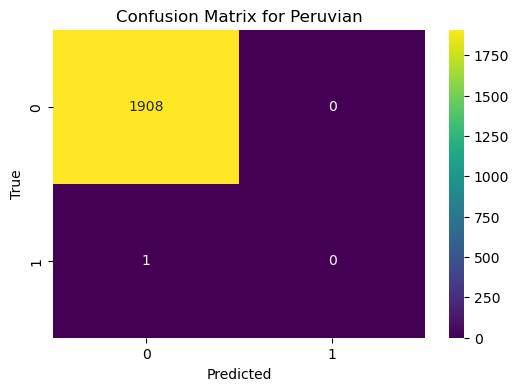

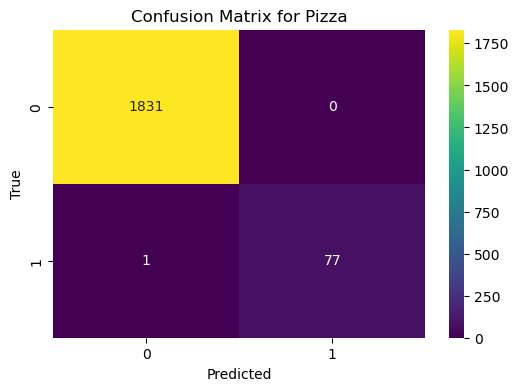

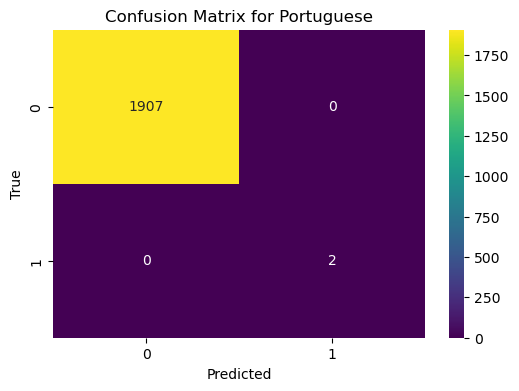

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


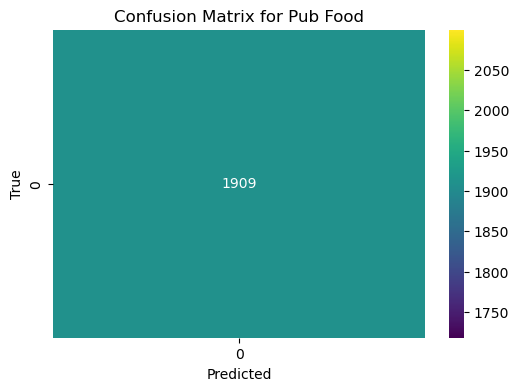

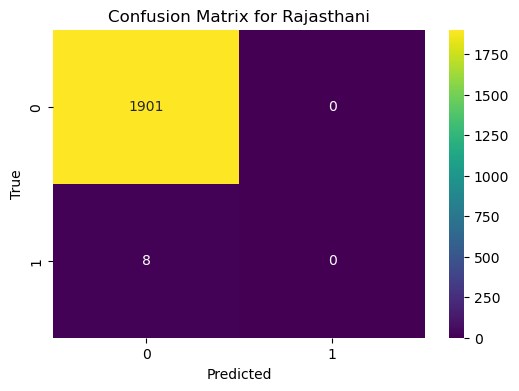

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


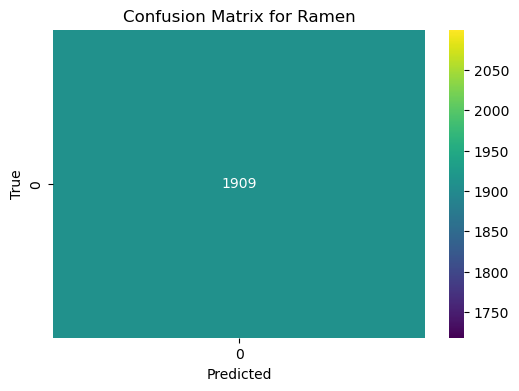

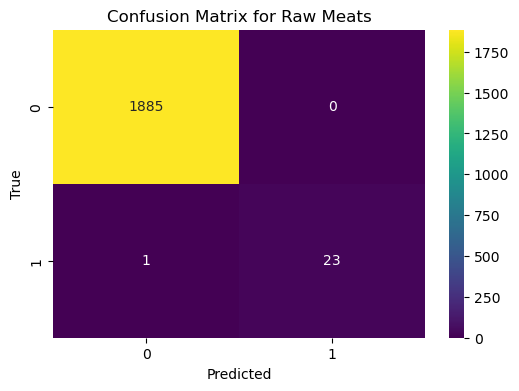

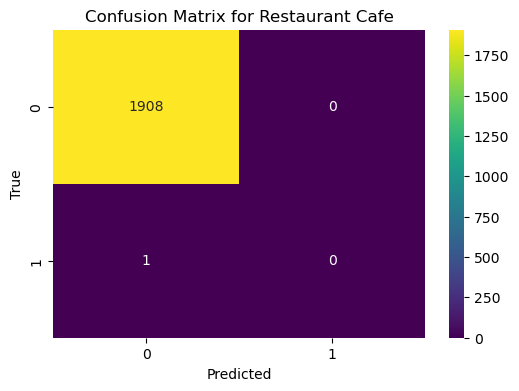

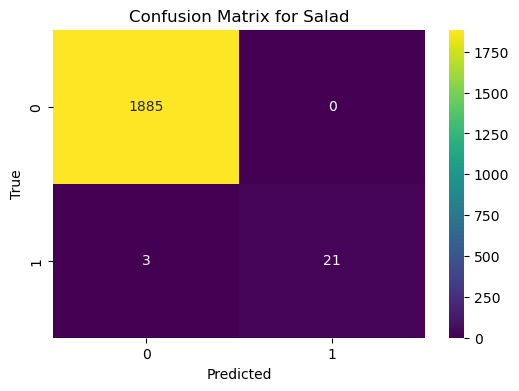

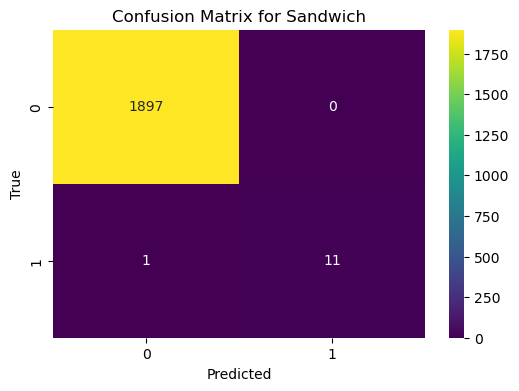

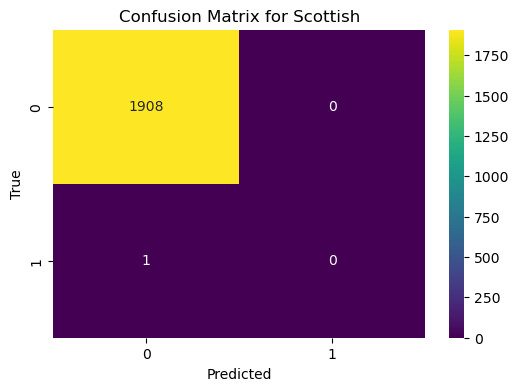

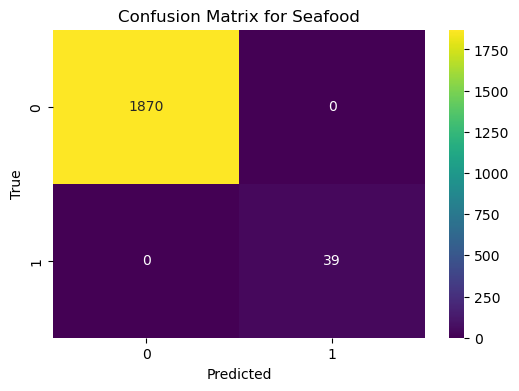

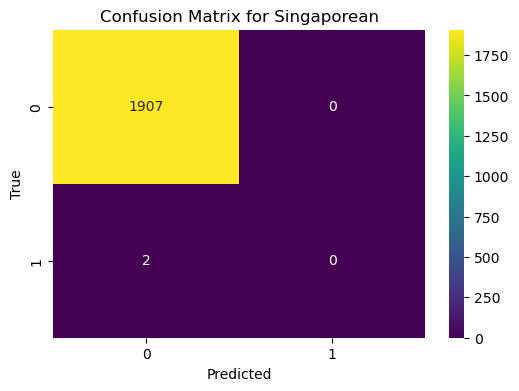

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


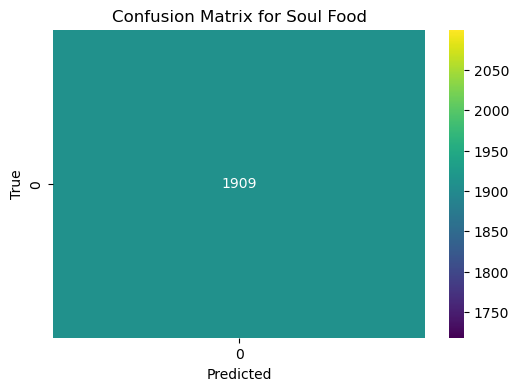

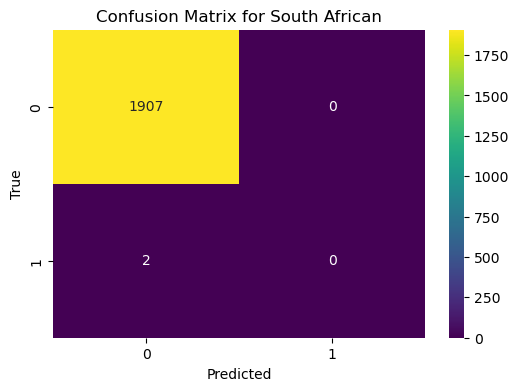

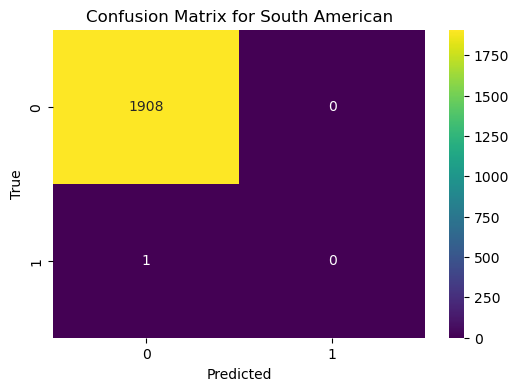

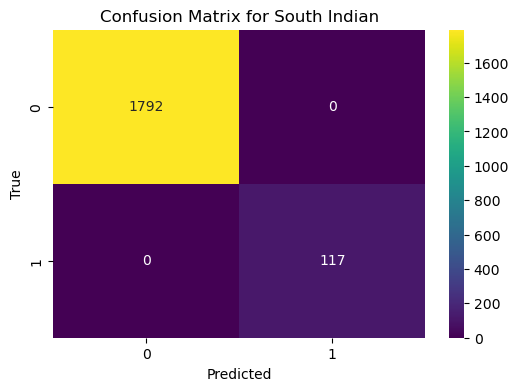

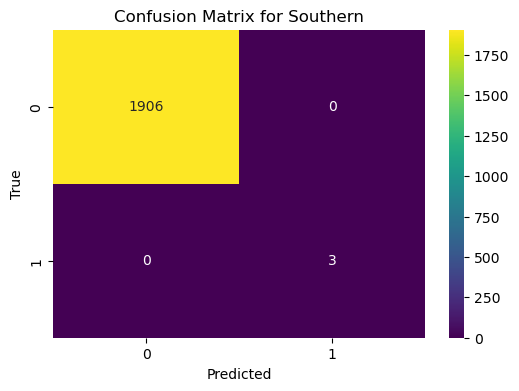

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


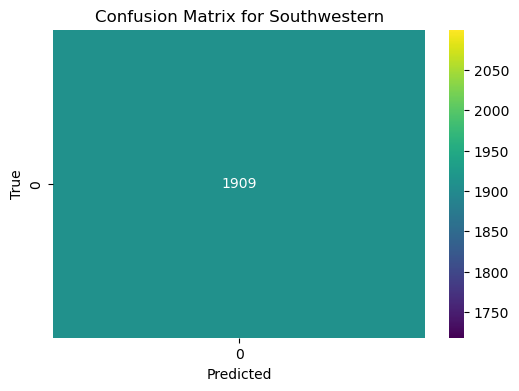

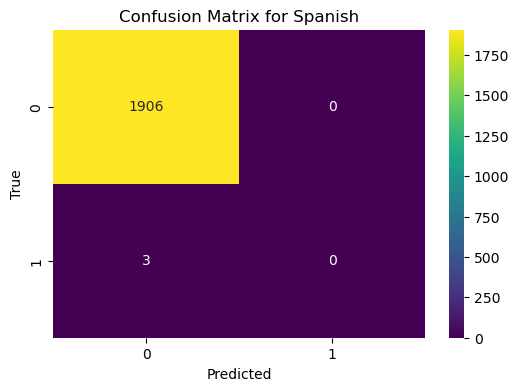

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


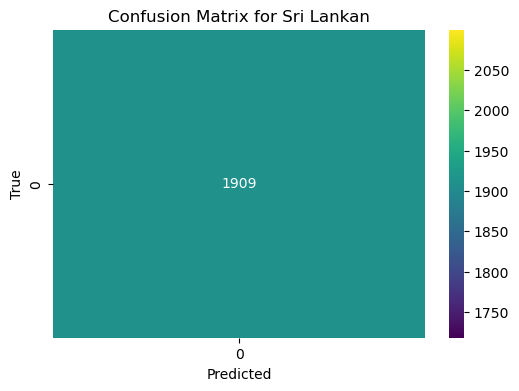

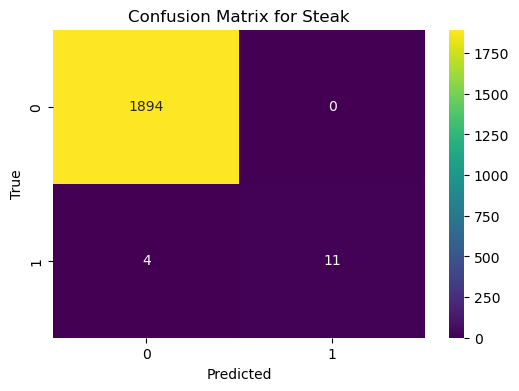

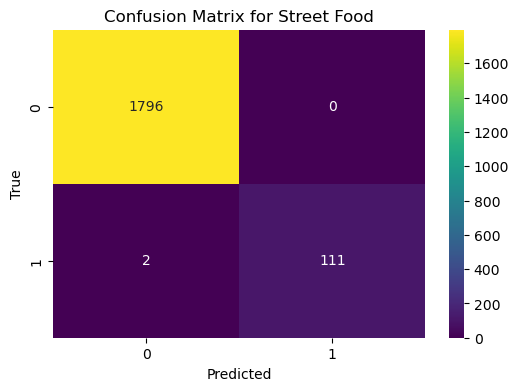

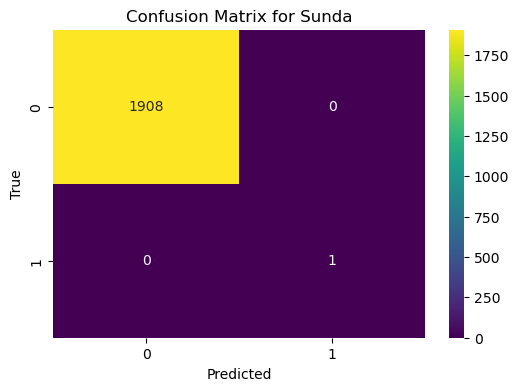

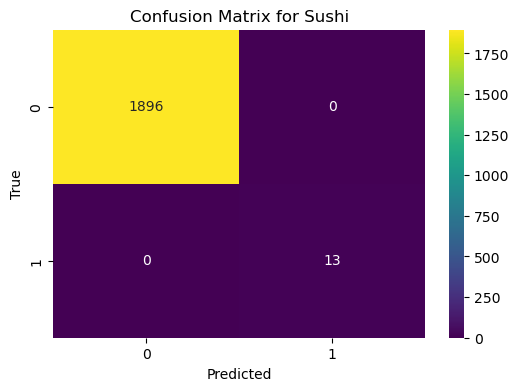

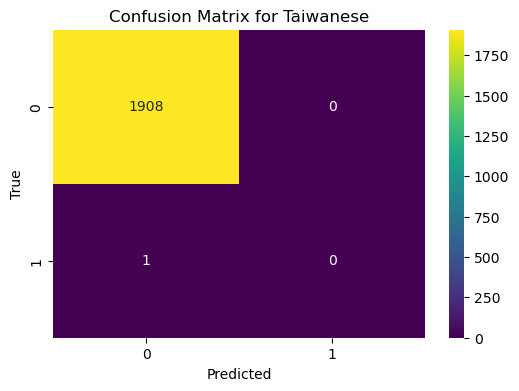

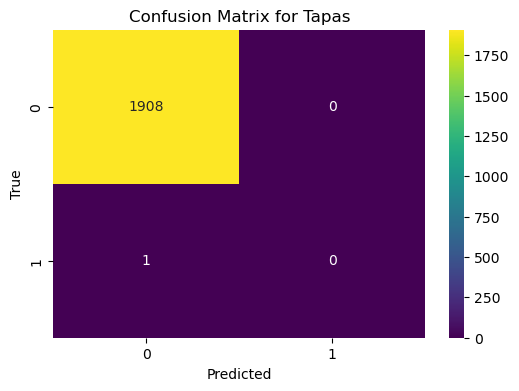

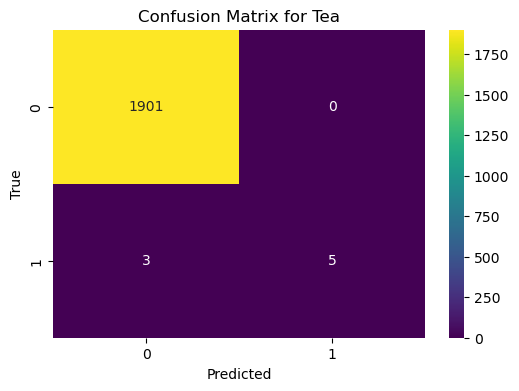

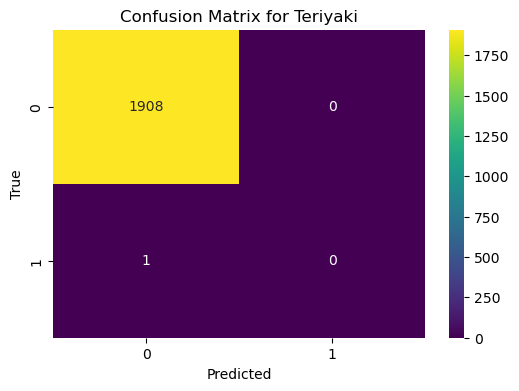

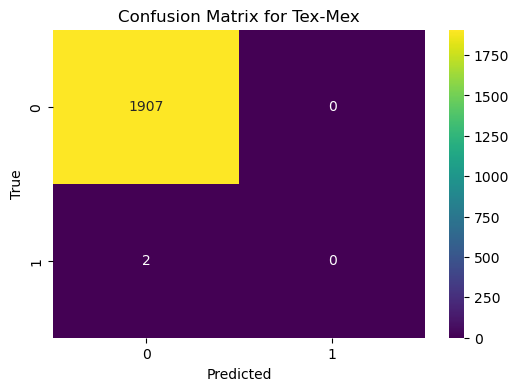

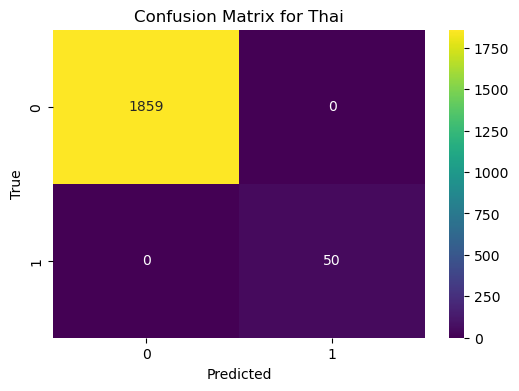

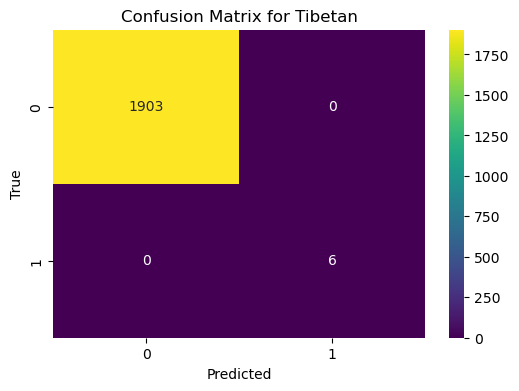

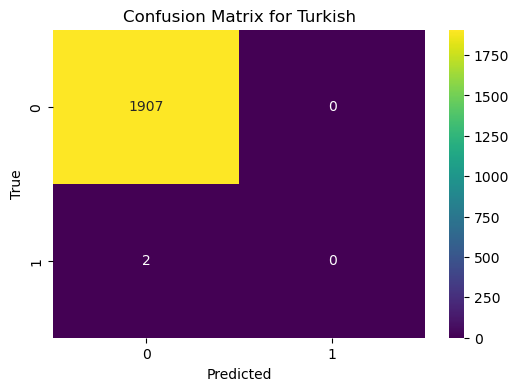

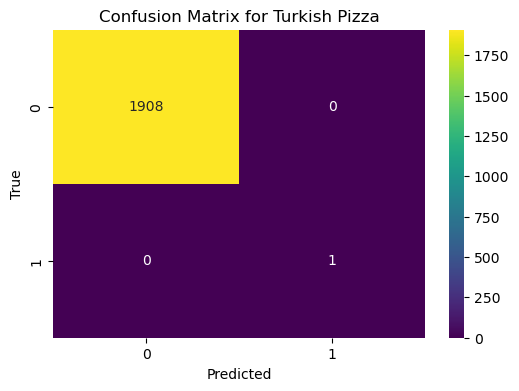

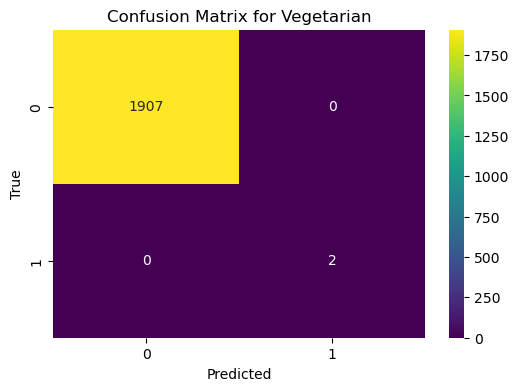

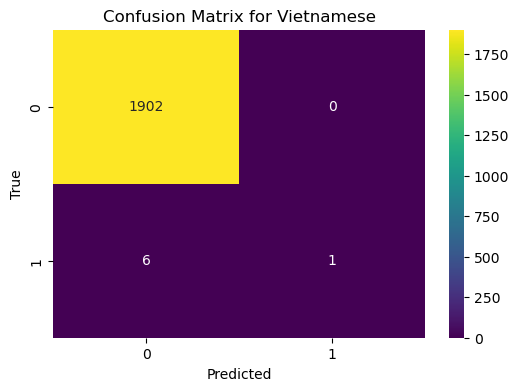

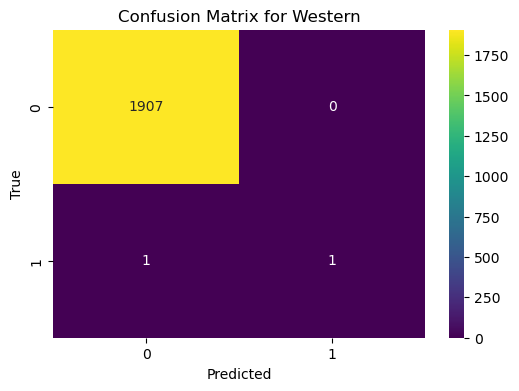

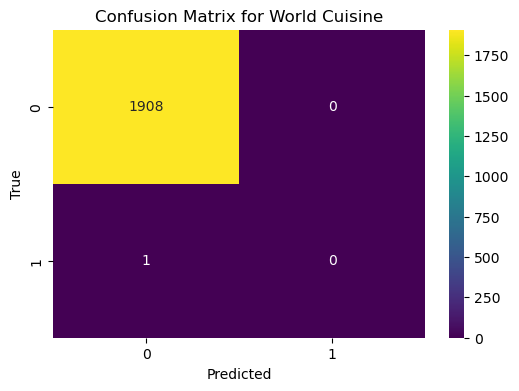

In [163]:
# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for i, cuisine in enumerate(mlb.classes_):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title(f'Confusion Matrix for {cuisine}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

The confusion matrix brings warning indicating that during the evaluation, there was a situation where only one label was found in either y_true or y_pred. This can happen when the test set or the predicted results contain only a subset of the classes, which leads to a confusion matrix with the wrong shape.

To handle this warning effectively, I will specify the labels parameter in the confusion matrix calculation.

In [114]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7633, 293), (1909, 293), (7633, 145), (1909, 145))

In [125]:
print(y_train.sum())
print(y_test.sum())

Afghani           10
African            5
American         317
Andhra             8
Arabian           26
                ... 
Turkish Pizza      7
Vegetarian        21
Vietnamese        14
Western            8
World Cuisine      3
Length: 145, dtype: int64
Afghani           4
African           3
American         73
Andhra            2
Arabian           2
                 ..
Turkish Pizza     1
Vegetarian        2
Vietnamese        7
Western           2
World Cuisine     1
Length: 145, dtype: int64


In [138]:
# new model that handle imbalance by using class_weight
from sklearn.ensemble import RandomForestClassifier

model_bal = MultiOutputClassifier(RandomForestClassifier(random_state=42, class_weight='balanced'))
model_bal.fit(X_train, y_train)

y_pred_bal = model_bal.predict(X_test)

In [141]:
# Model balance accuraacy and report without worning
from sklearn.metrics import classification_report

report_bal = classification_report(y_test, y_pred_bal, target_names=mlb.classes_, zero_division=0)
accuracy_bal = accuracy_score(y_test, y_pred_bal)
print(f"accuracy after refining: {accuracy}")
print(f"Classification Report:\n {report_bal}")

accuracy after refining: 0.9188056574122577
Classification Report:
                    precision    recall  f1-score   support

          Afghani       0.00      0.00      0.00         4
          African       1.00      0.67      0.80         3
         American       1.00      0.99      0.99        73
           Andhra       1.00      0.50      0.67         2
          Arabian       1.00      1.00      1.00         2
        Argentine       0.00      0.00      0.00         1
         Armenian       0.00      0.00      0.00         0
            Asian       1.00      0.96      0.98        50
     Asian Fusion       0.00      0.00      0.00         1
         Assamese       0.00      0.00      0.00         0
       Australian       0.00      0.00      0.00         1
           Awadhi       0.00      0.00      0.00         0
              BBQ       1.00      0.75      0.86         8
           Bakery       1.00      0.97      0.98       135
         Bar Food       1.00      0.85      0.

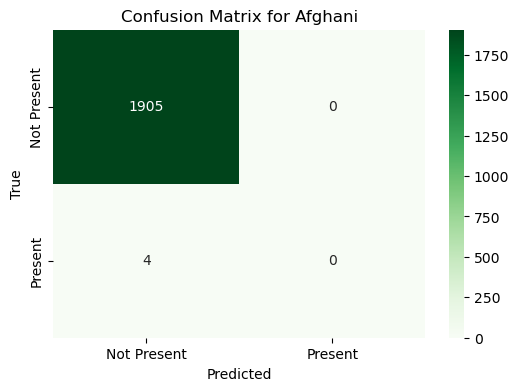

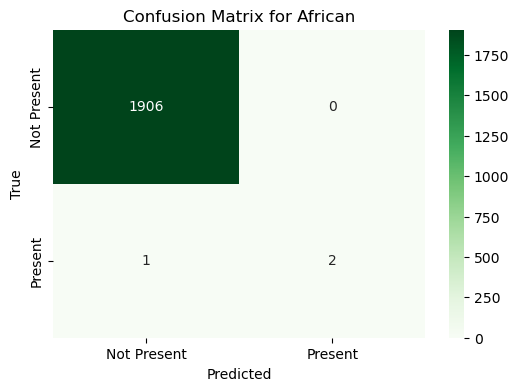

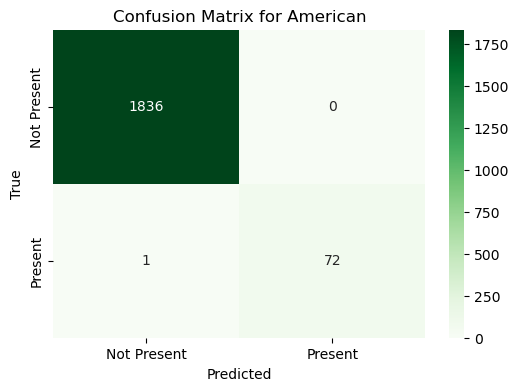

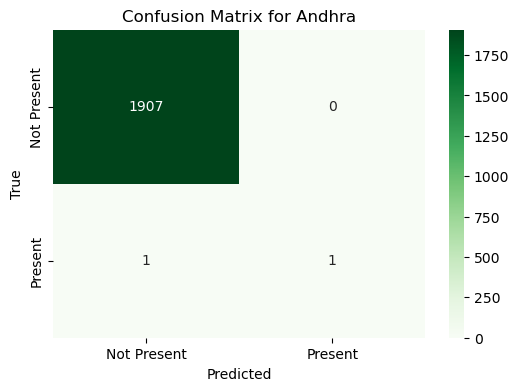

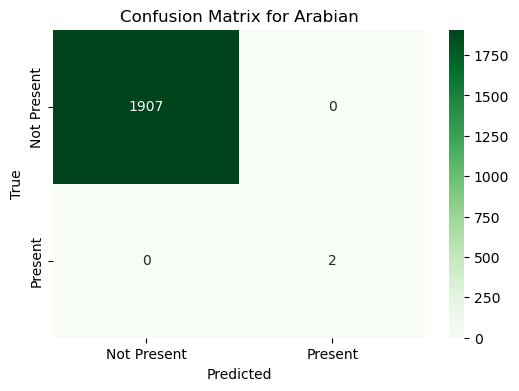

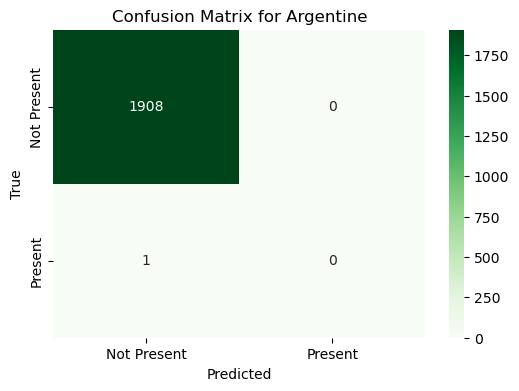

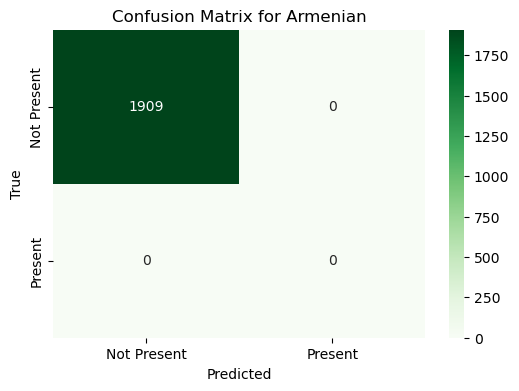

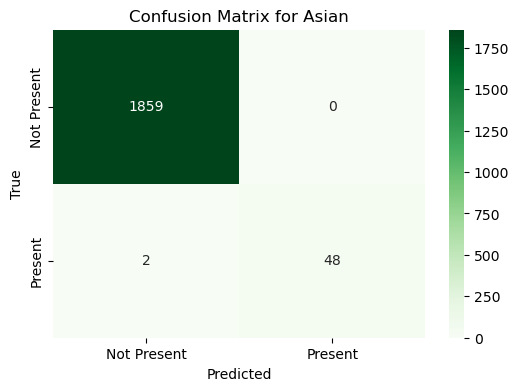

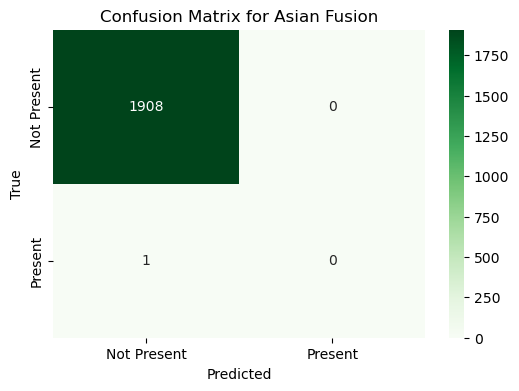

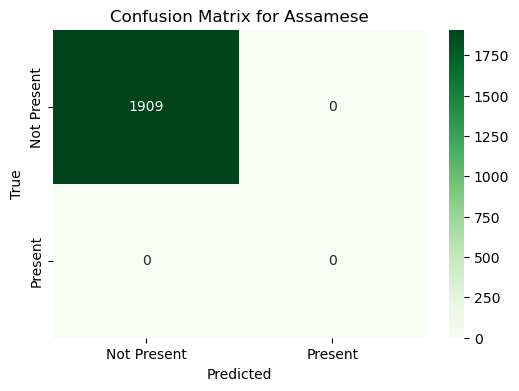

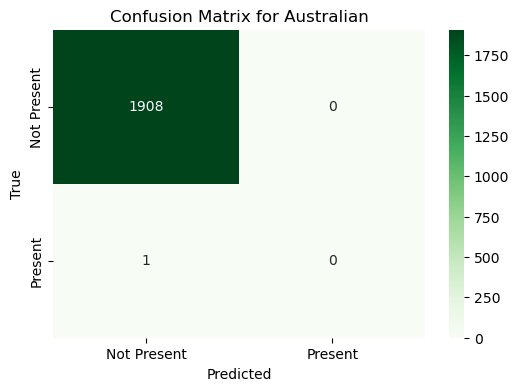

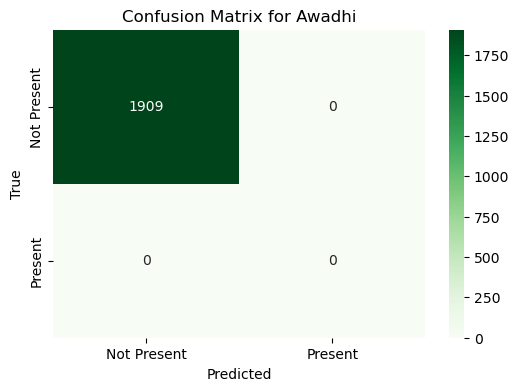

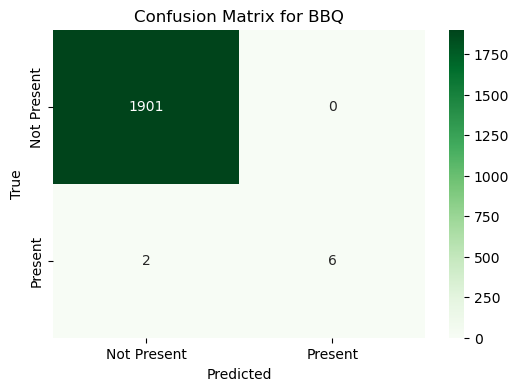

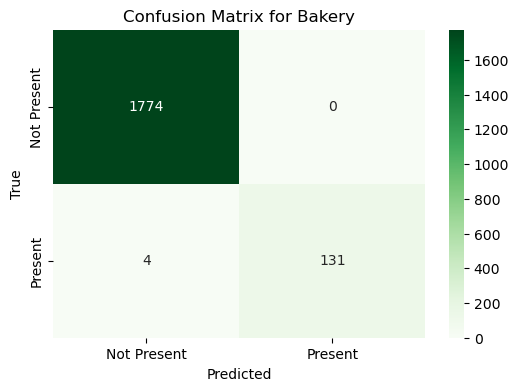

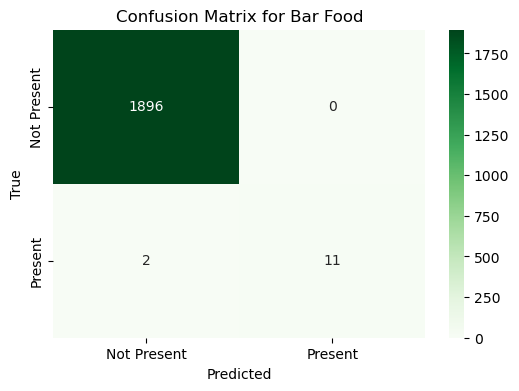

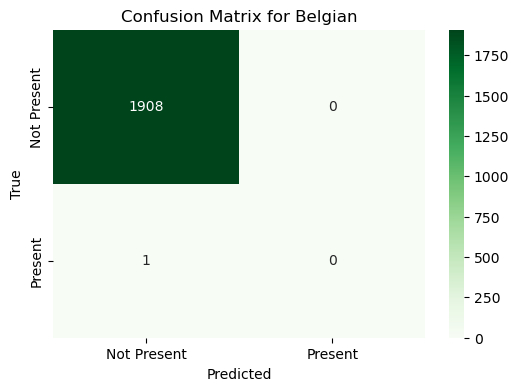

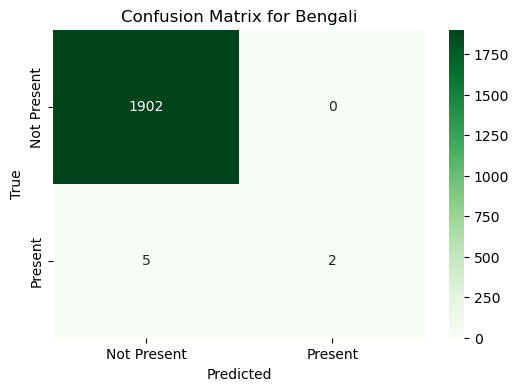

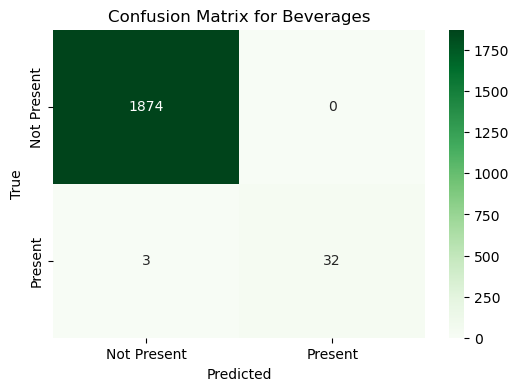

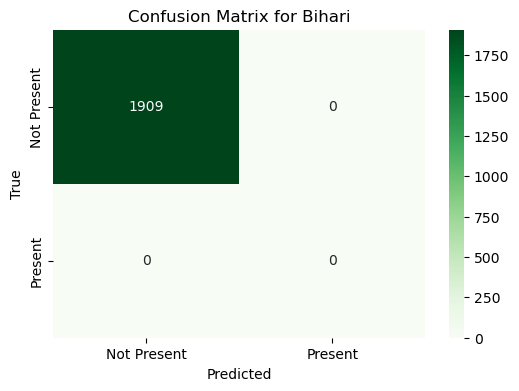

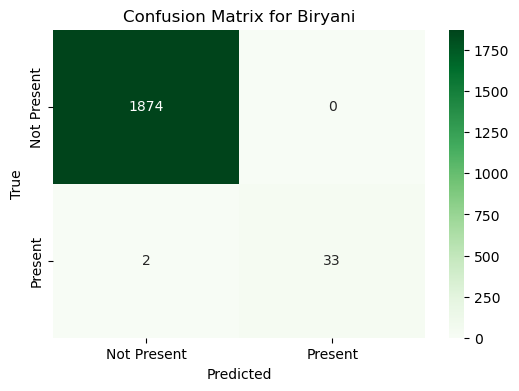

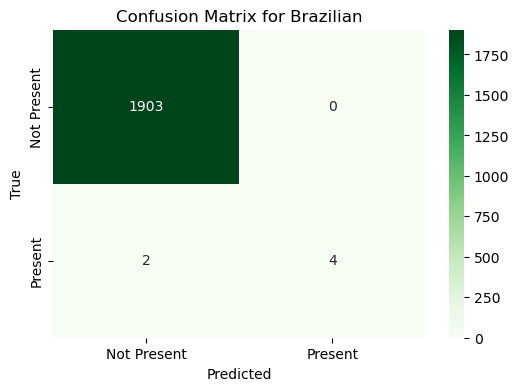

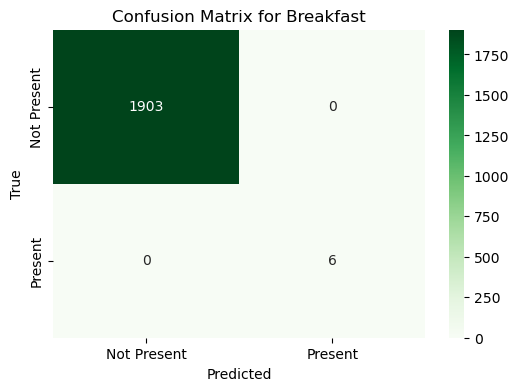

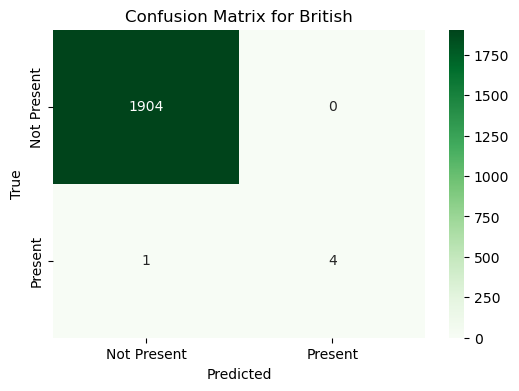

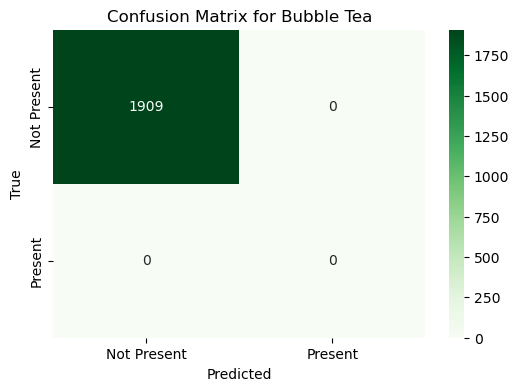

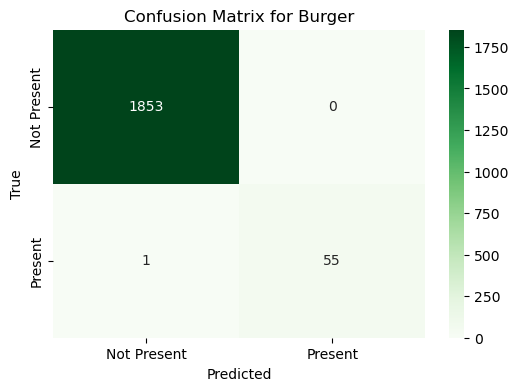

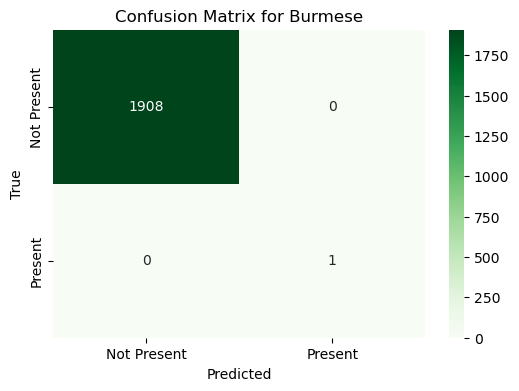

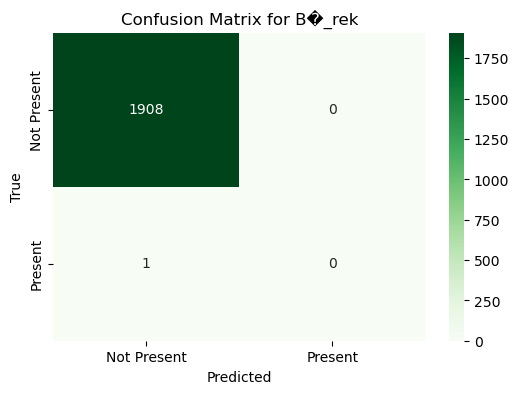

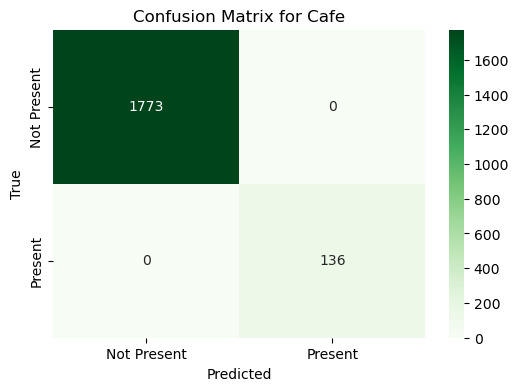

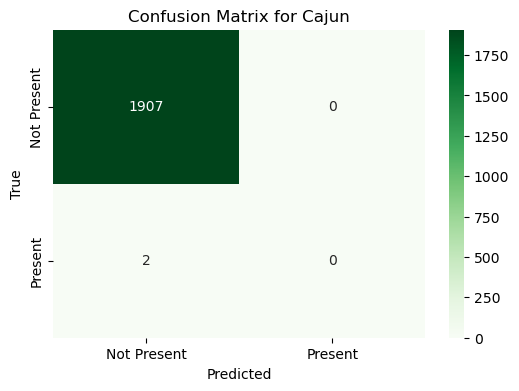

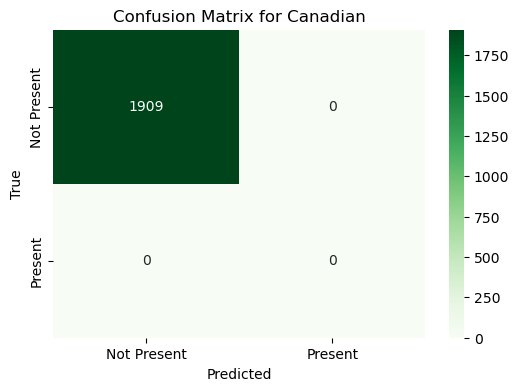

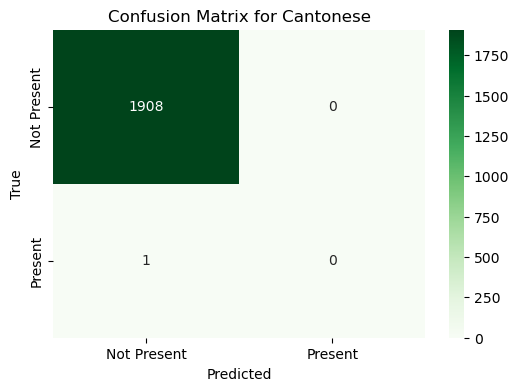

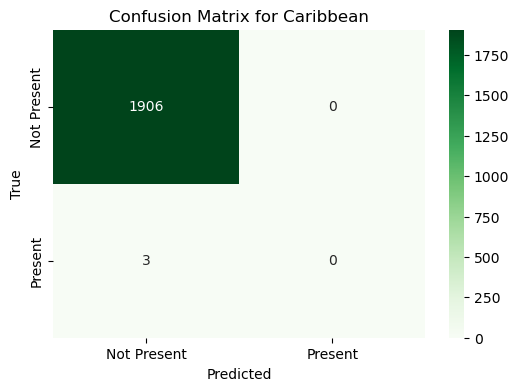

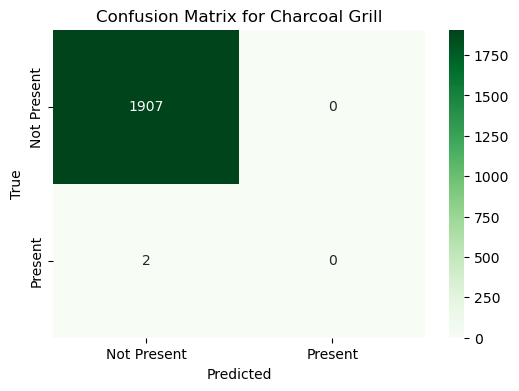

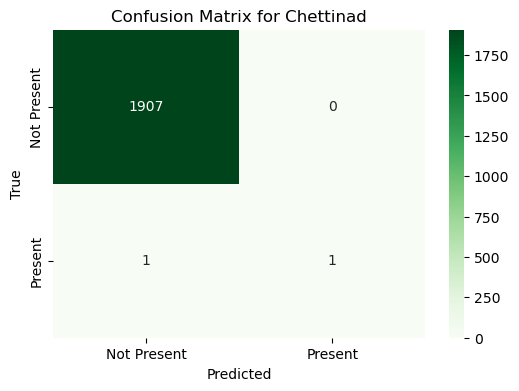

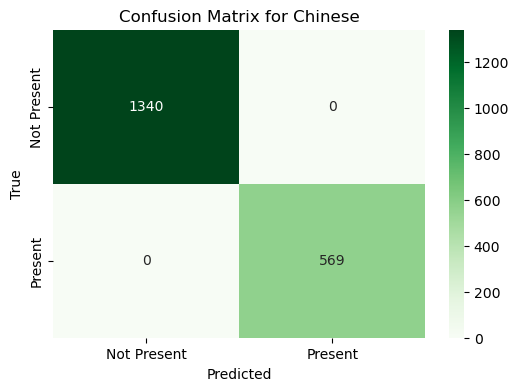

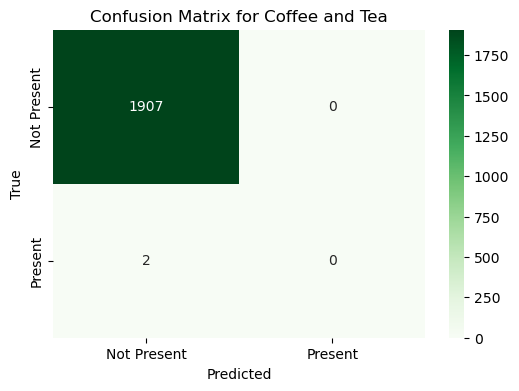

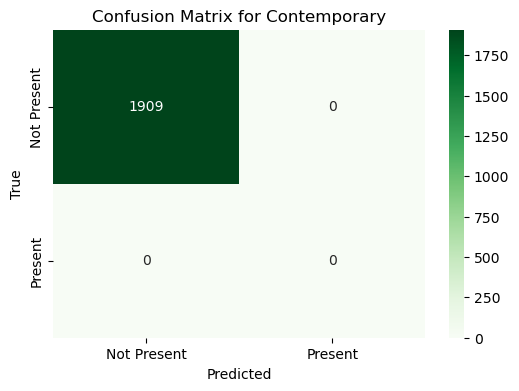

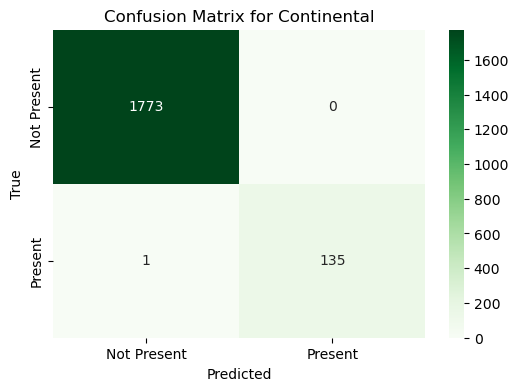

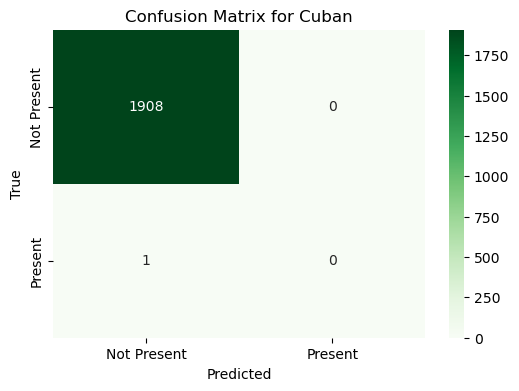

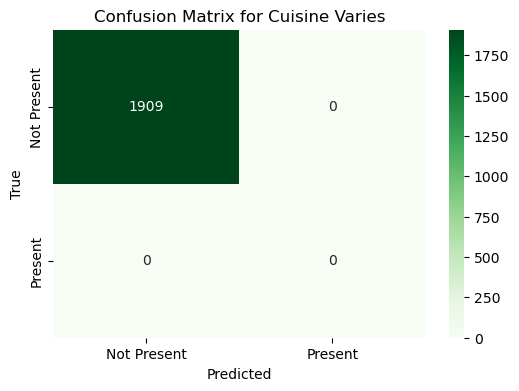

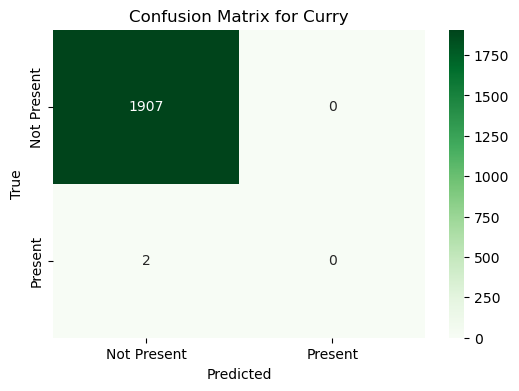

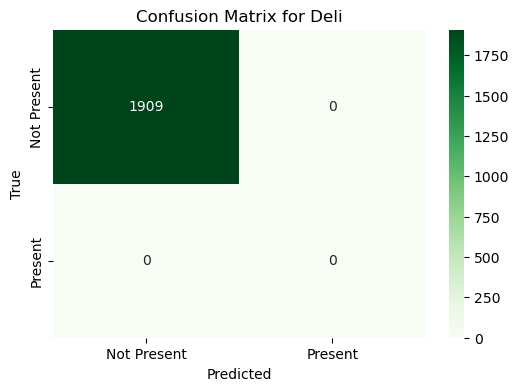

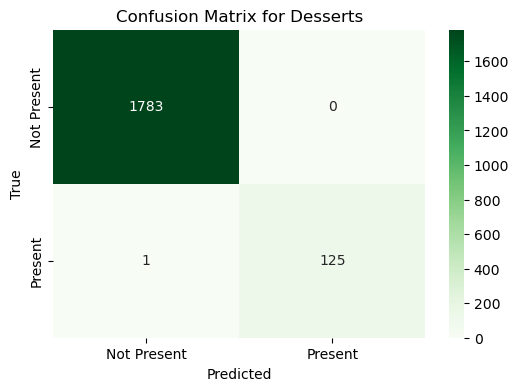

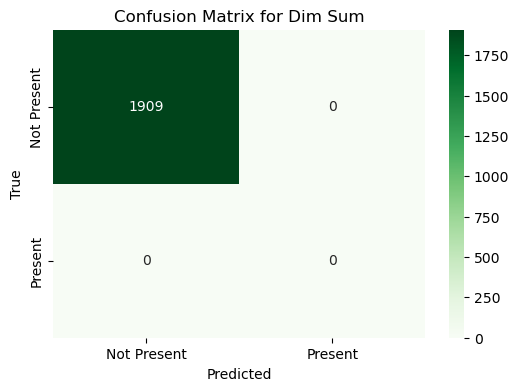

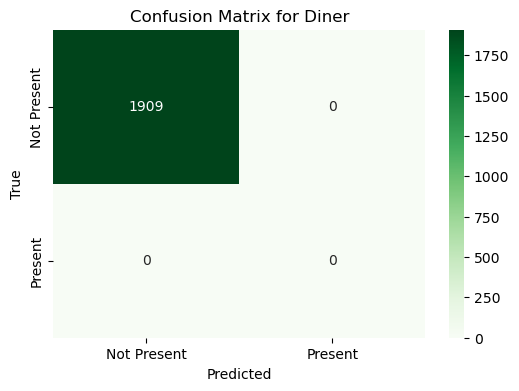

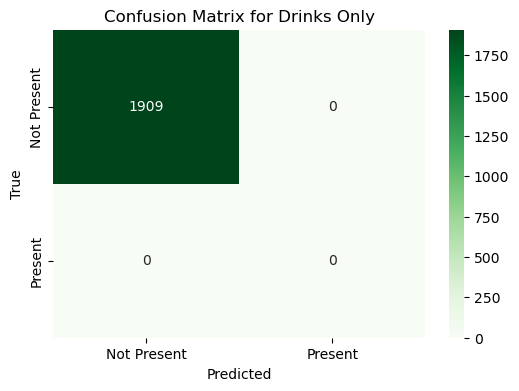

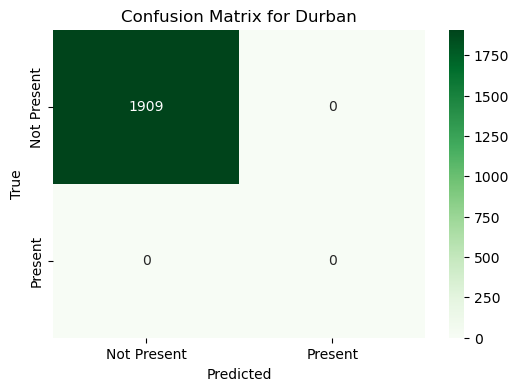

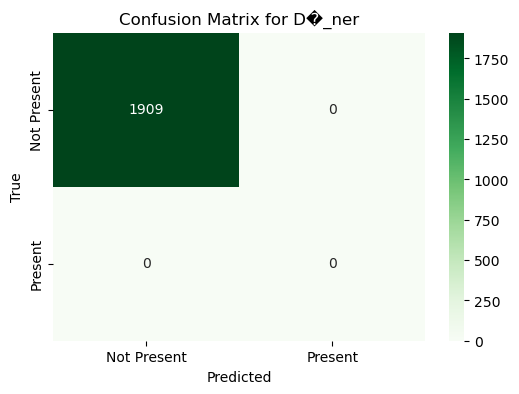

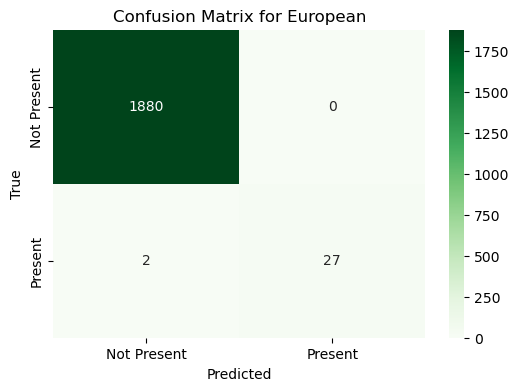

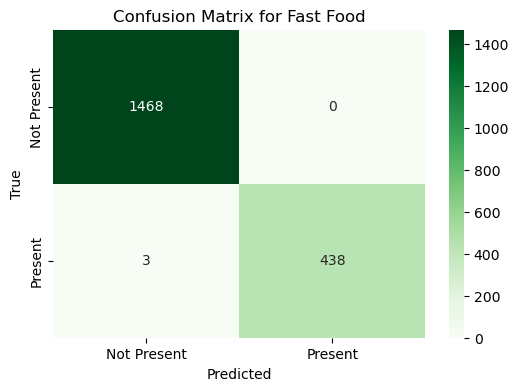

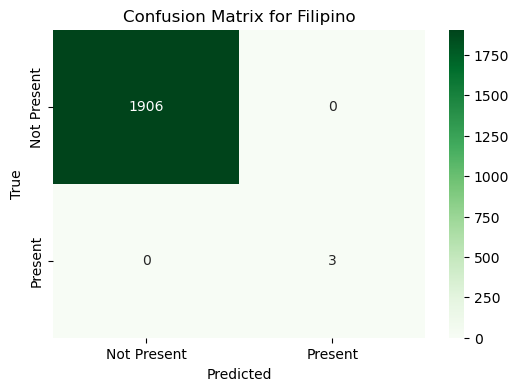

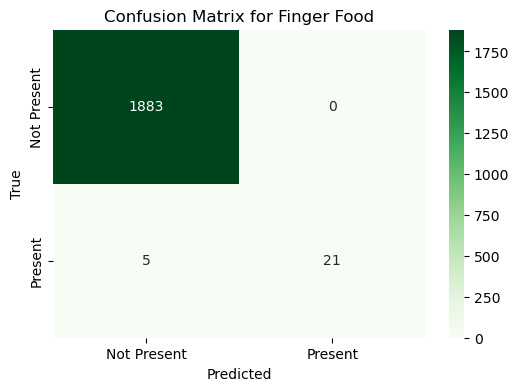

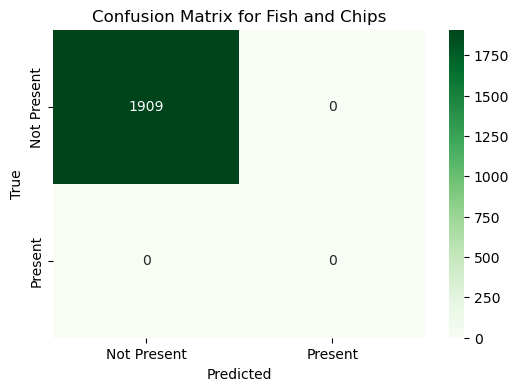

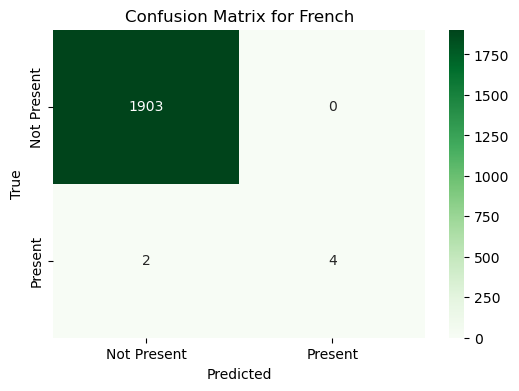

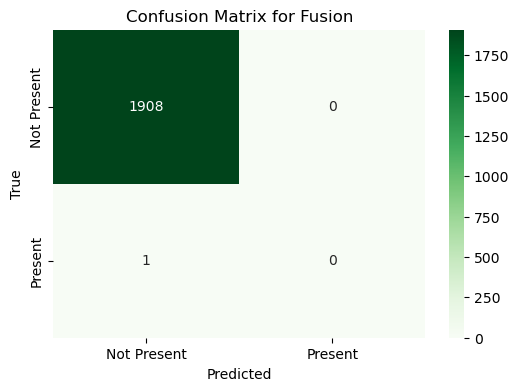

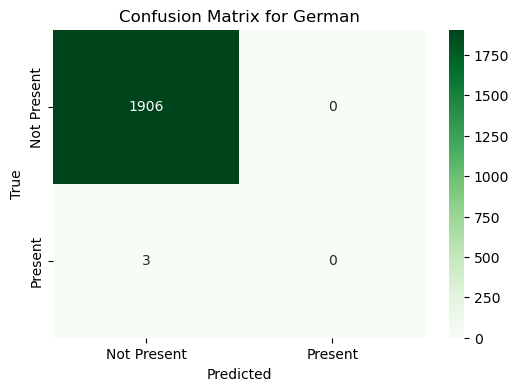

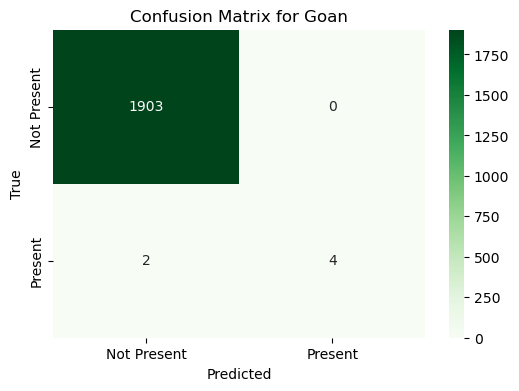

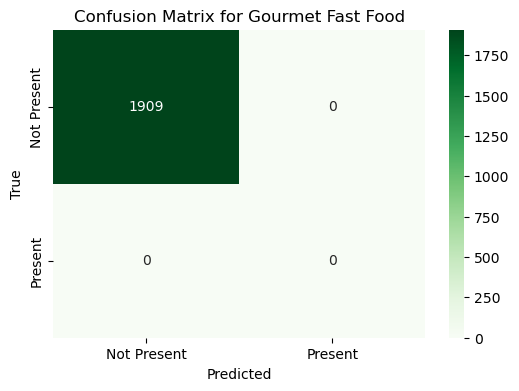

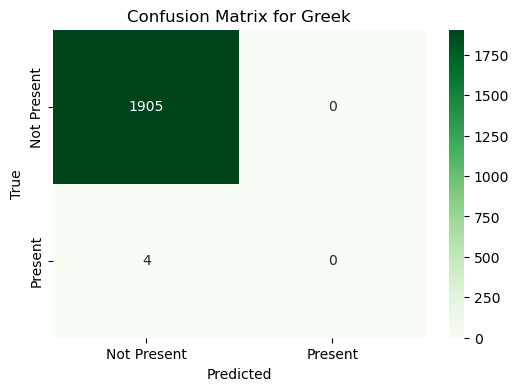

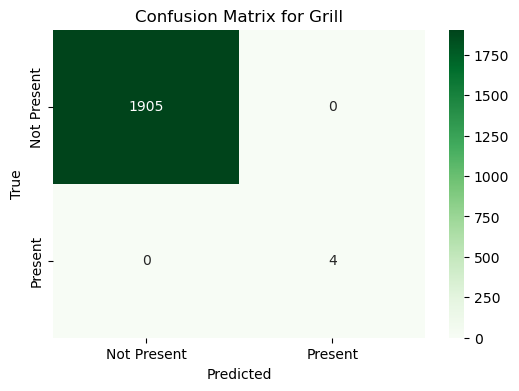

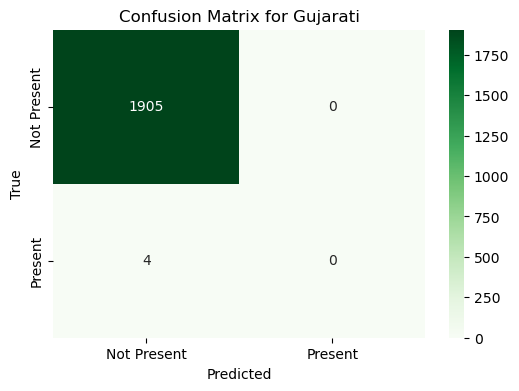

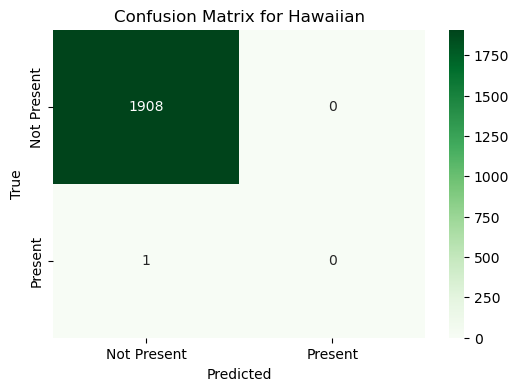

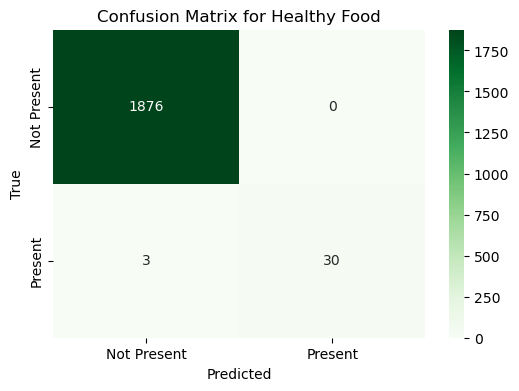

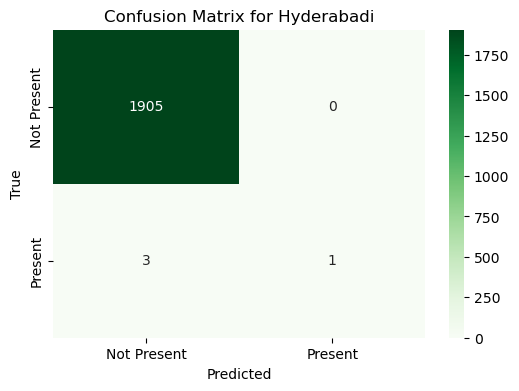

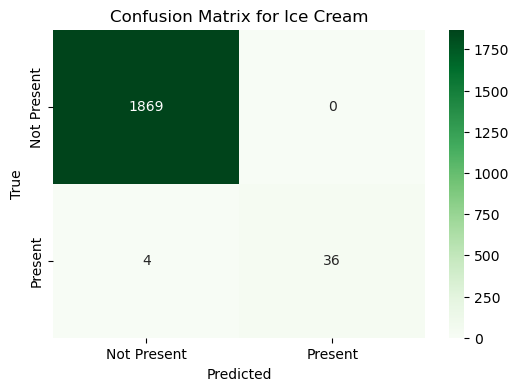

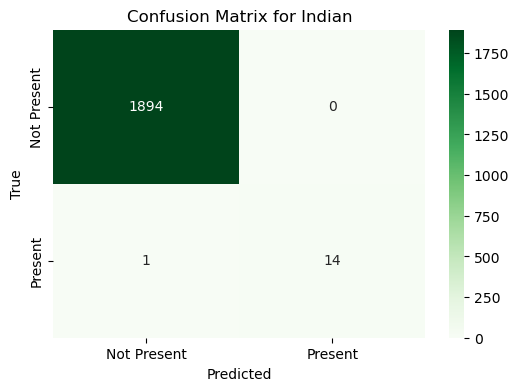

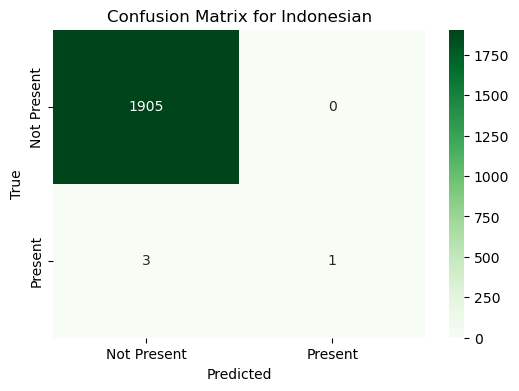

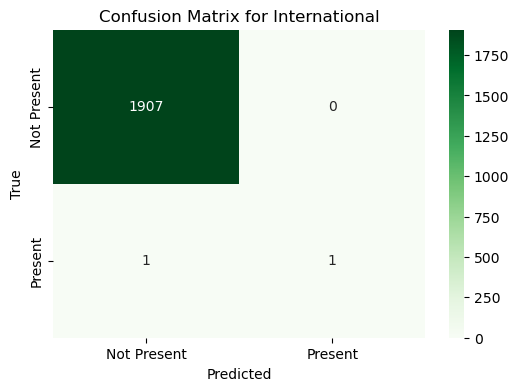

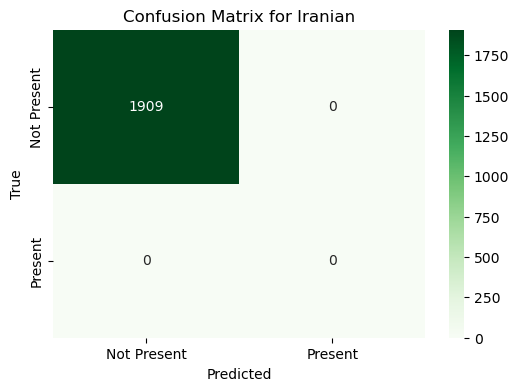

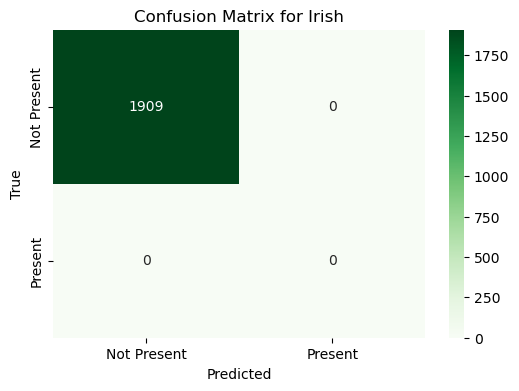

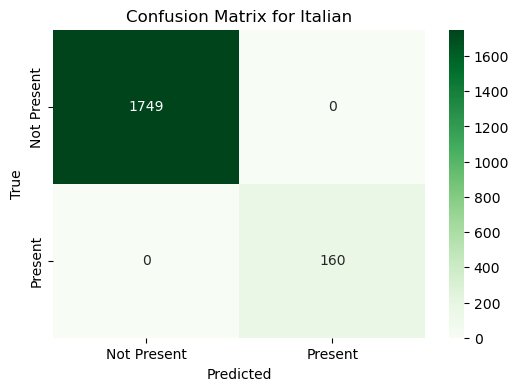

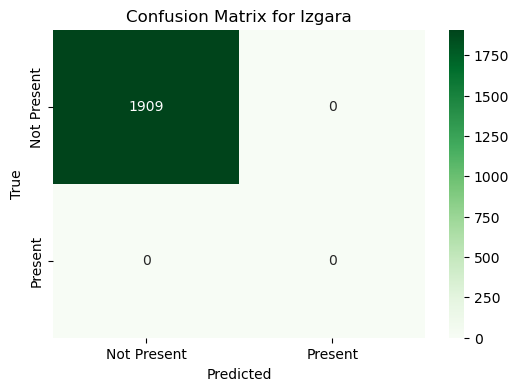

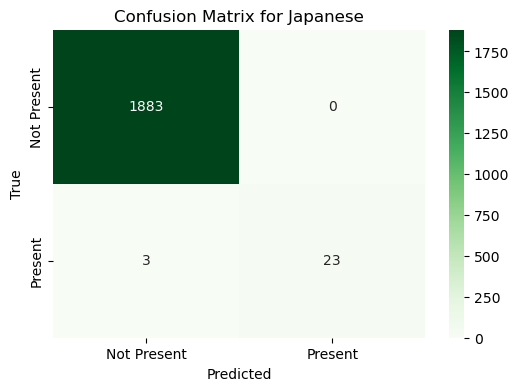

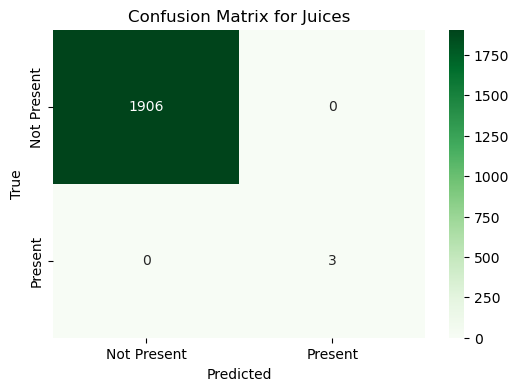

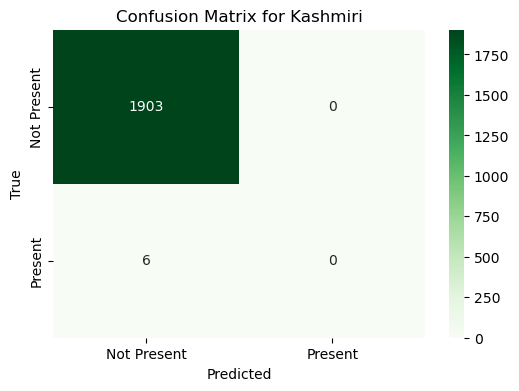

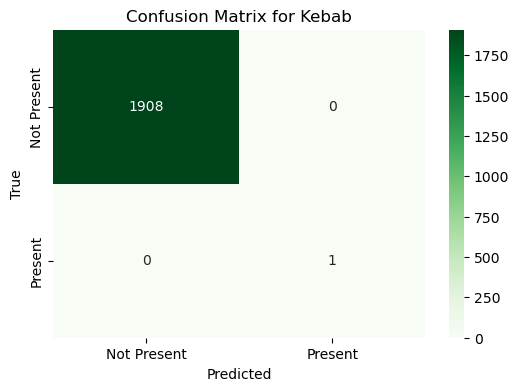

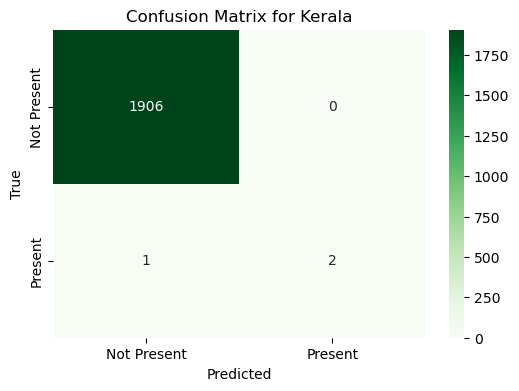

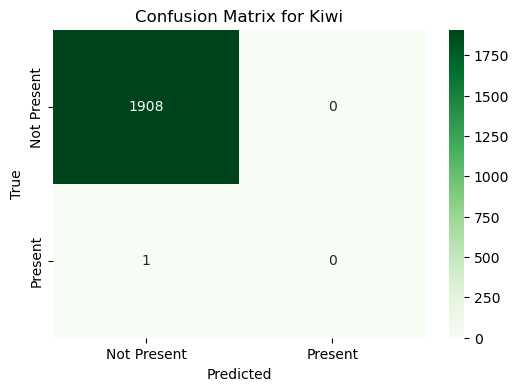

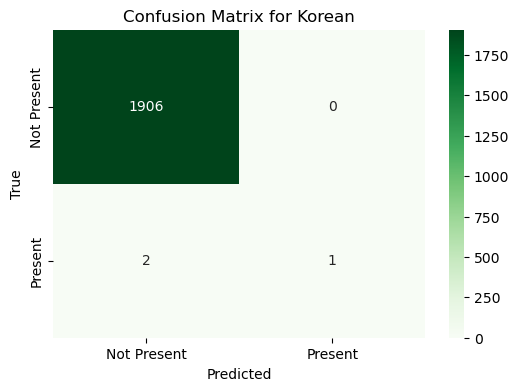

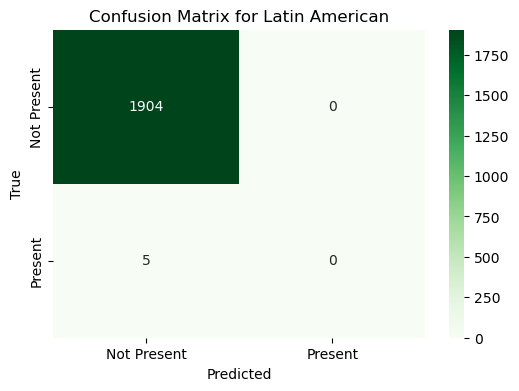

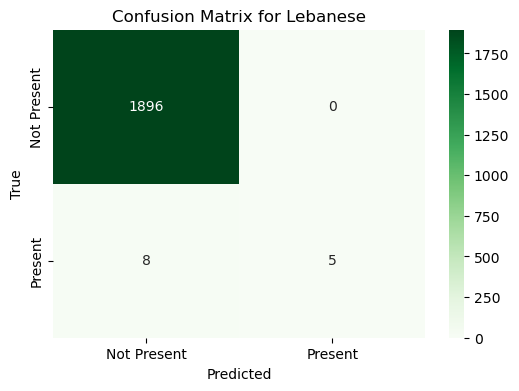

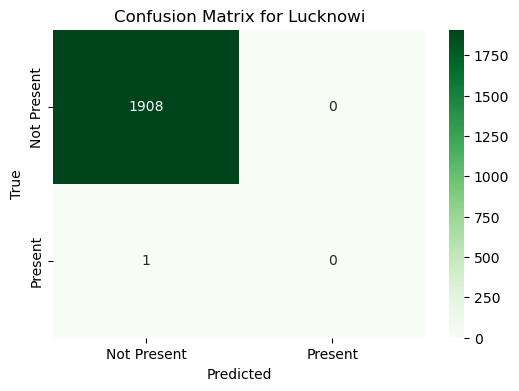

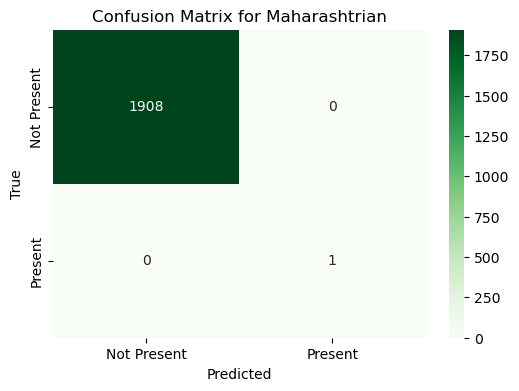

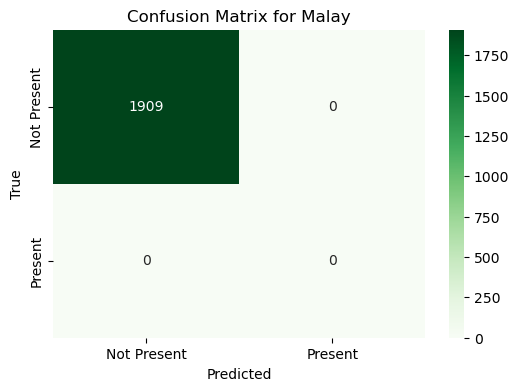

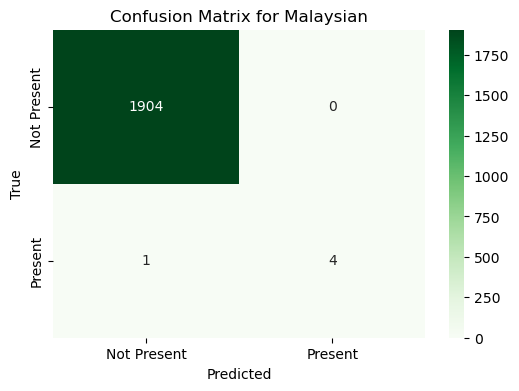

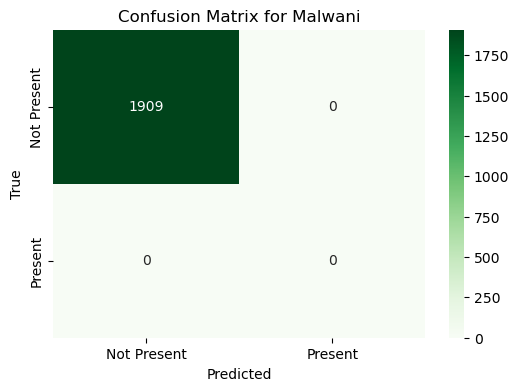

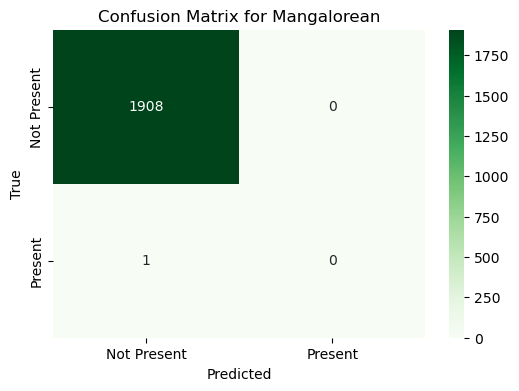

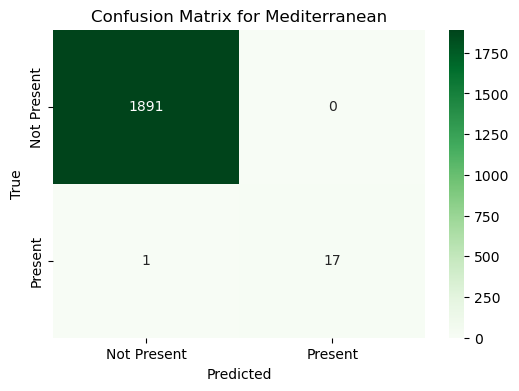

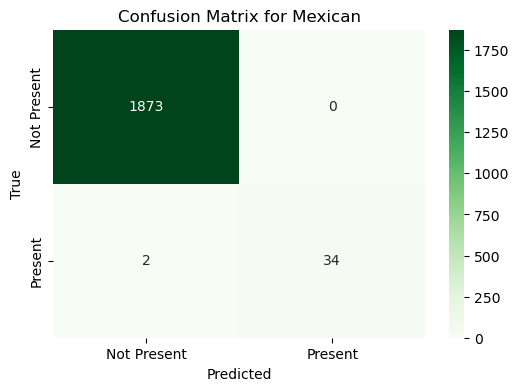

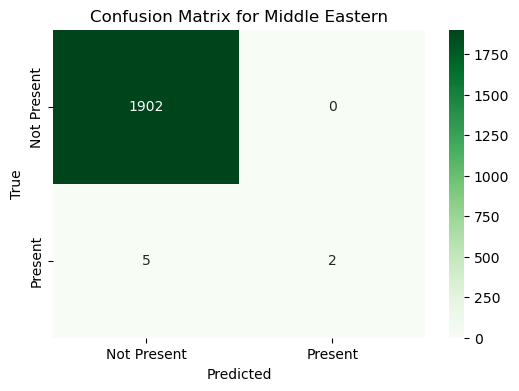

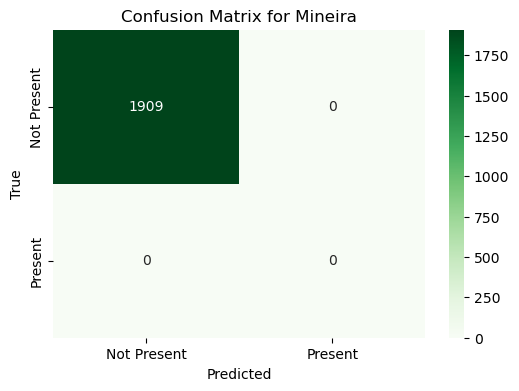

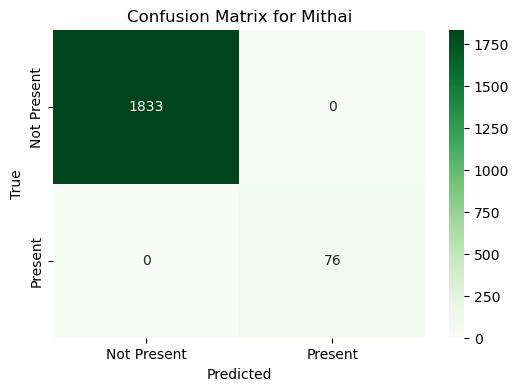

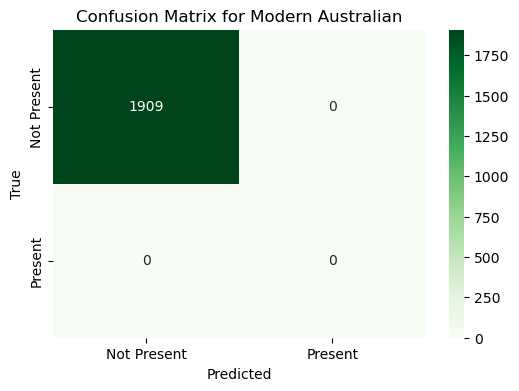

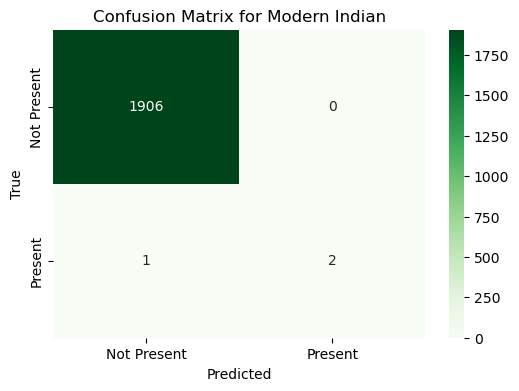

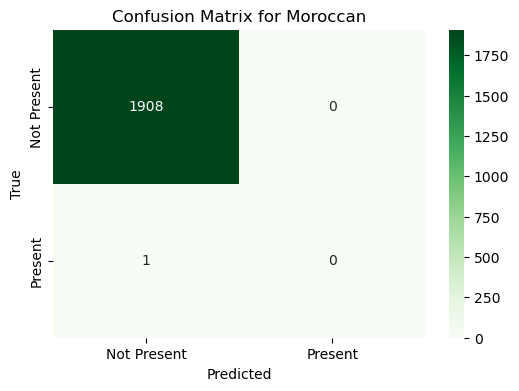

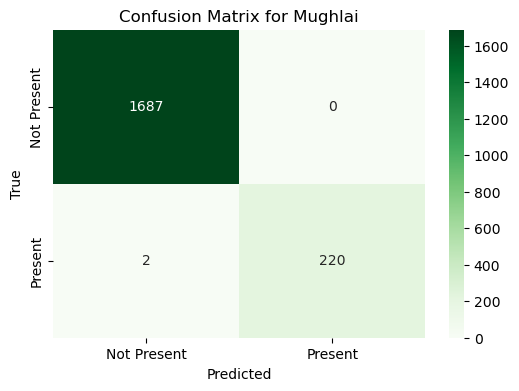

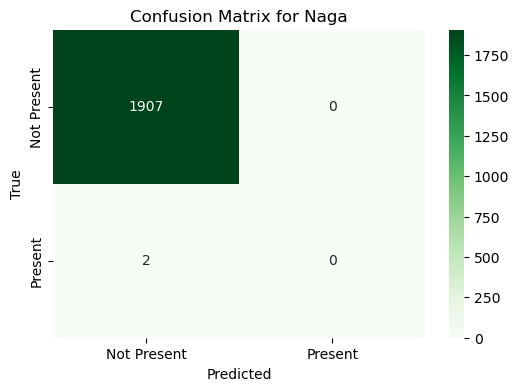

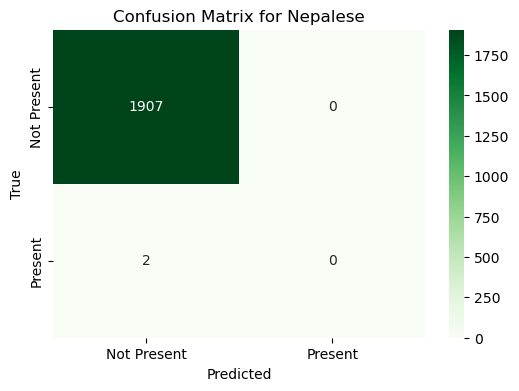

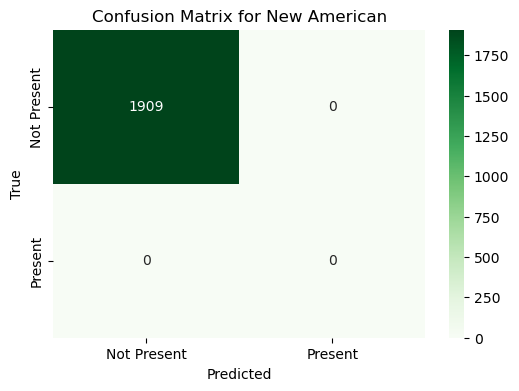

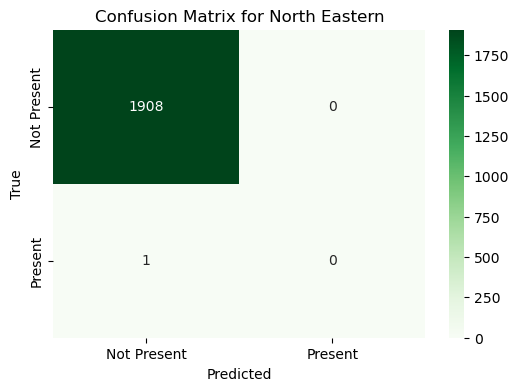

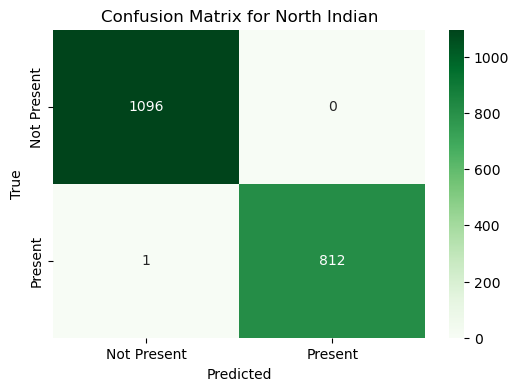

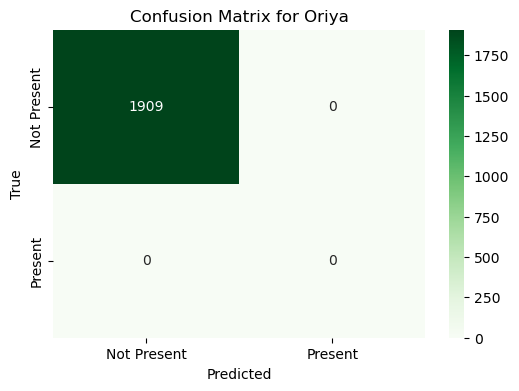

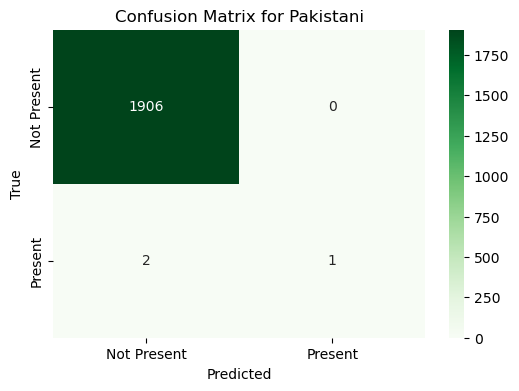

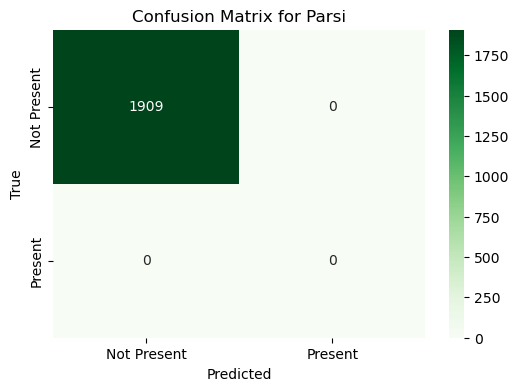

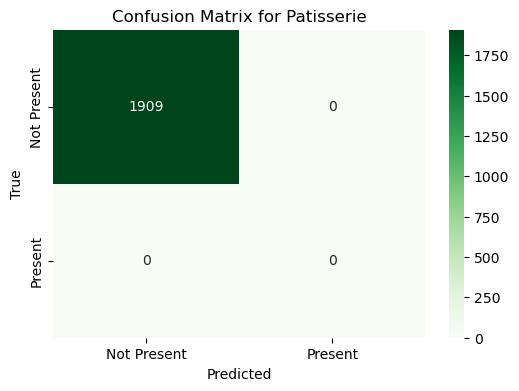

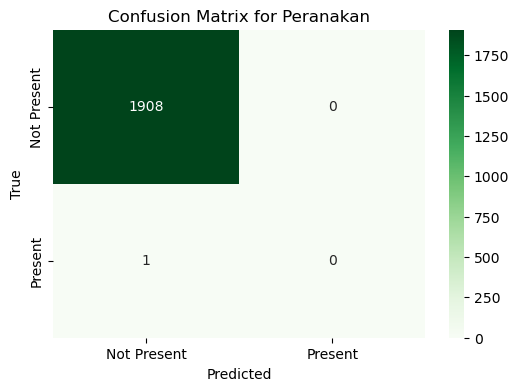

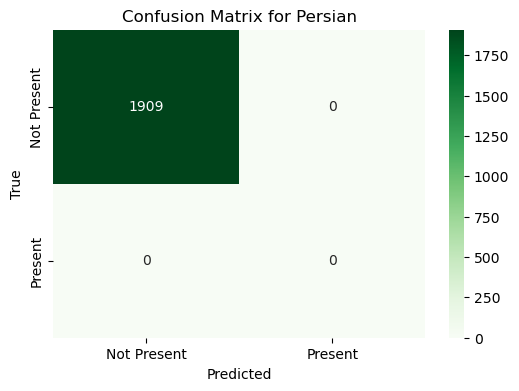

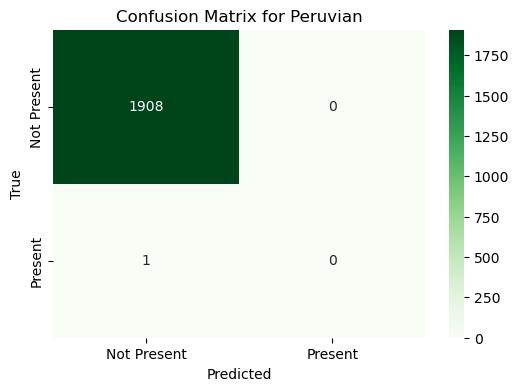

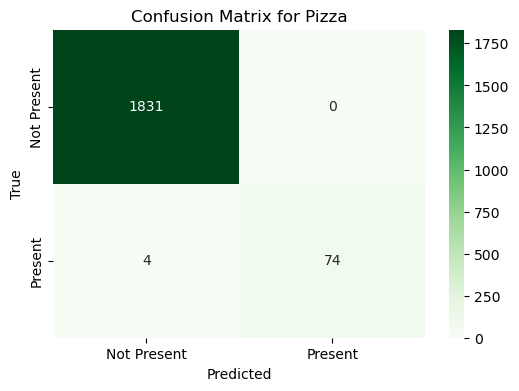

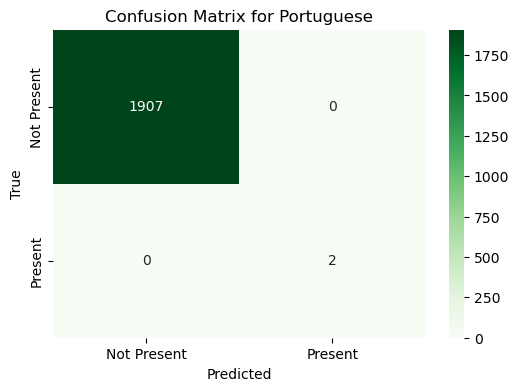

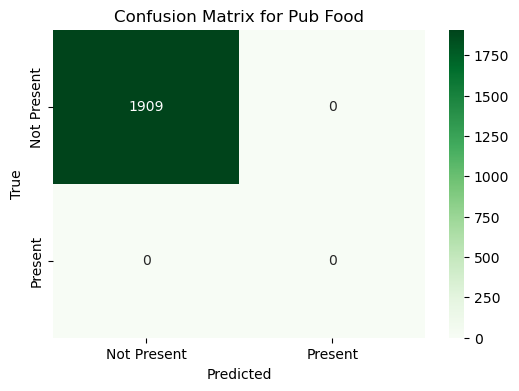

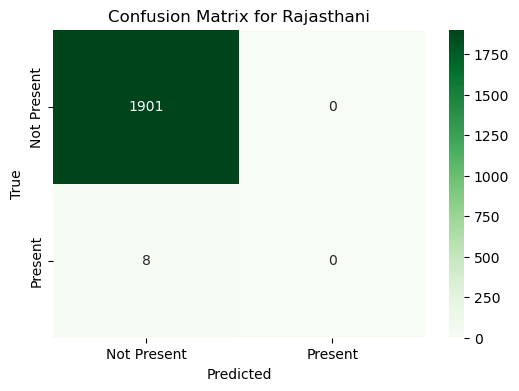

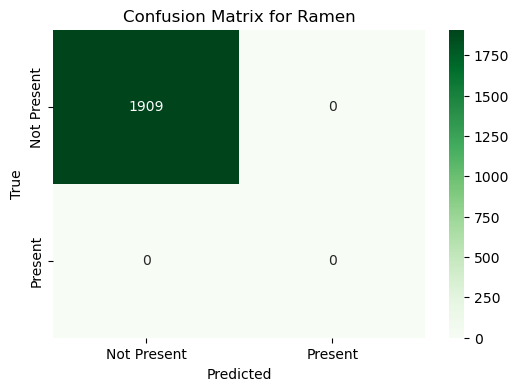

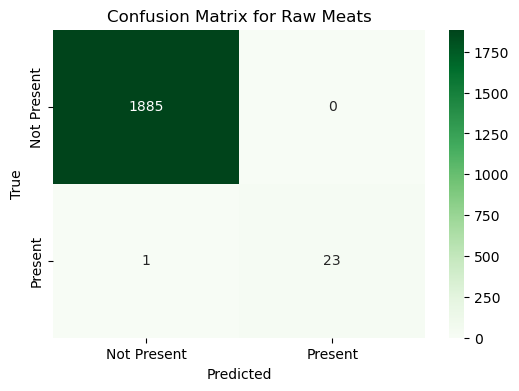

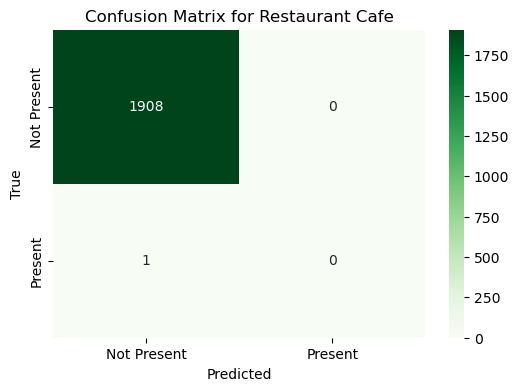

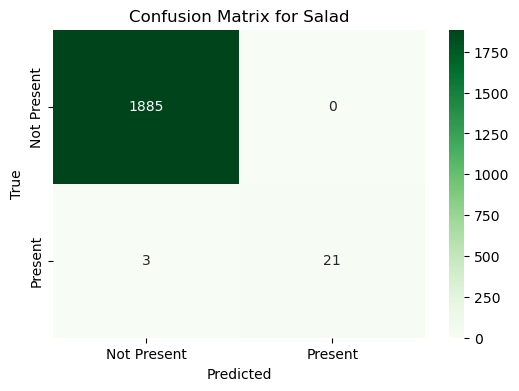

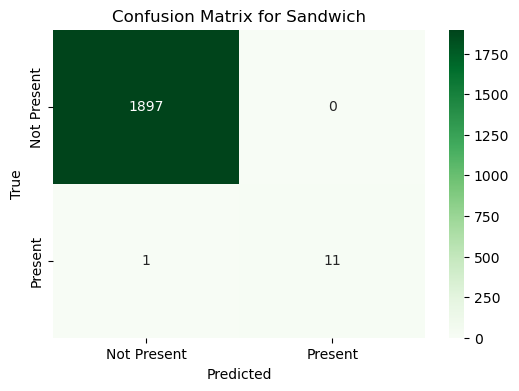

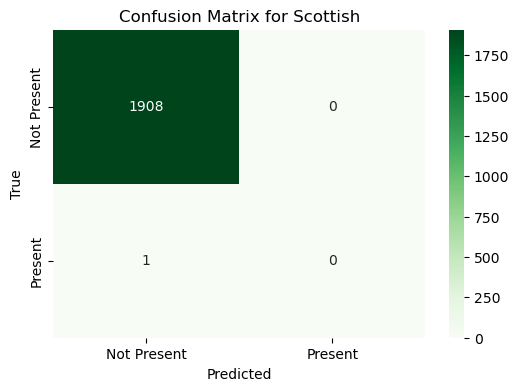

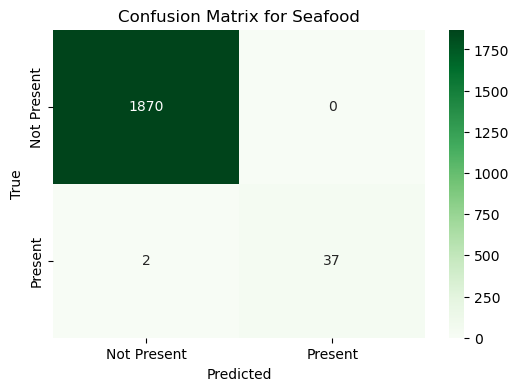

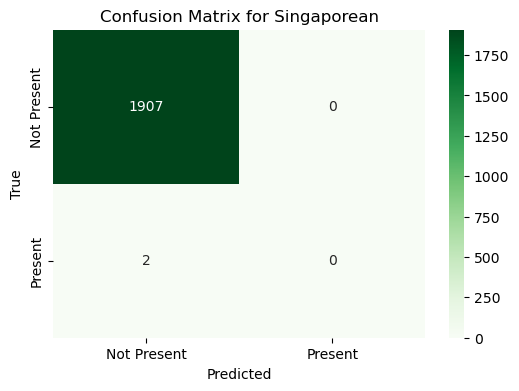

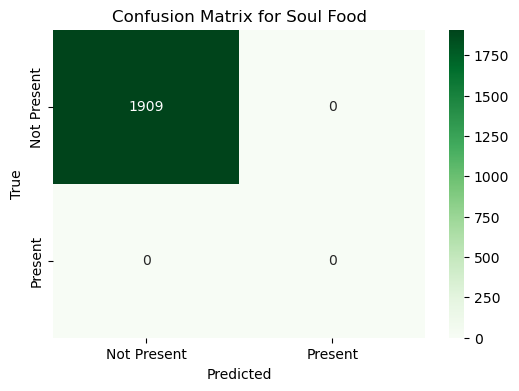

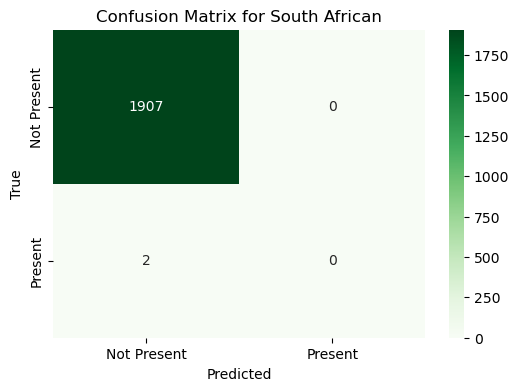

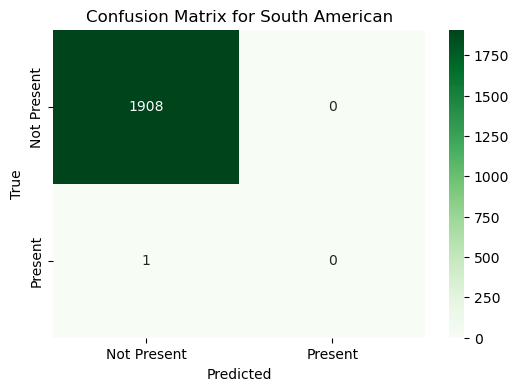

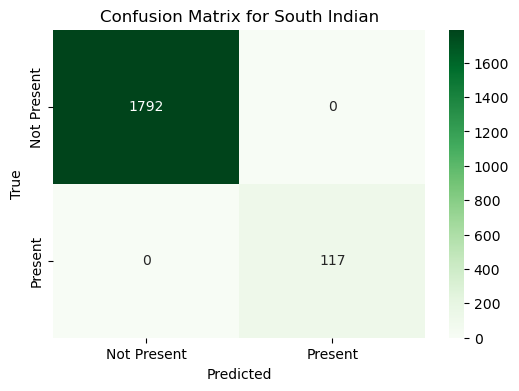

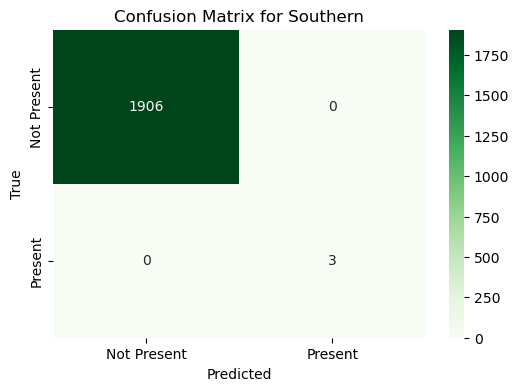

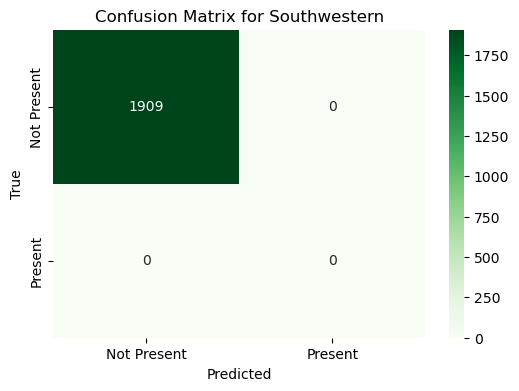

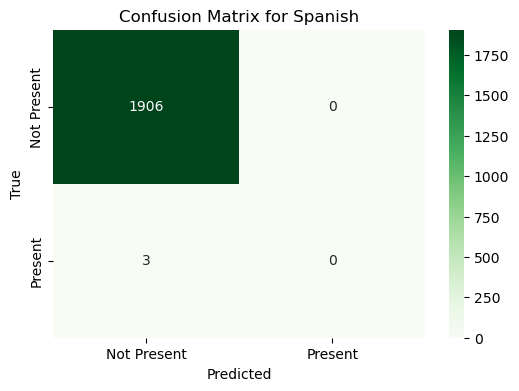

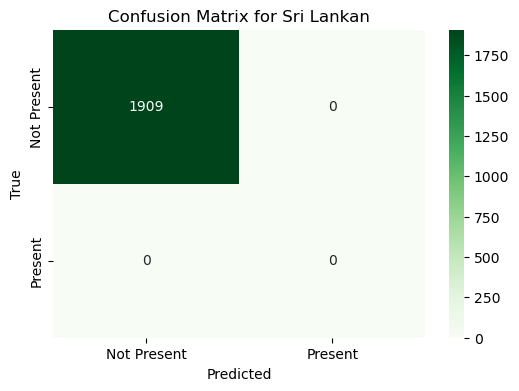

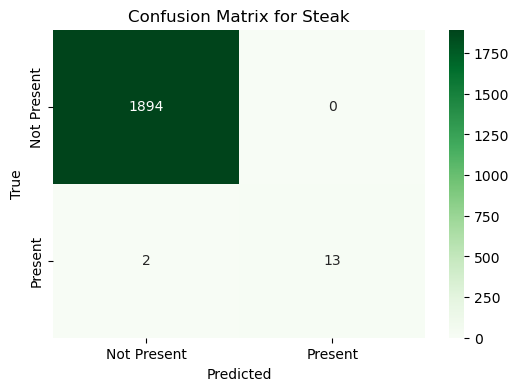

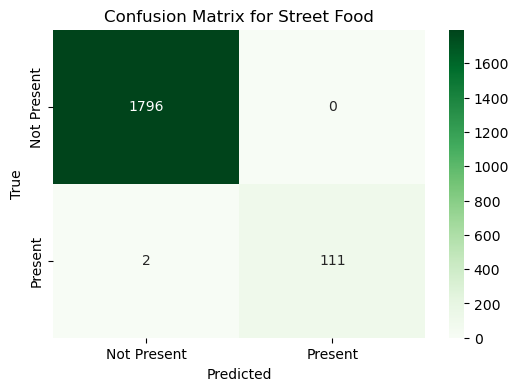

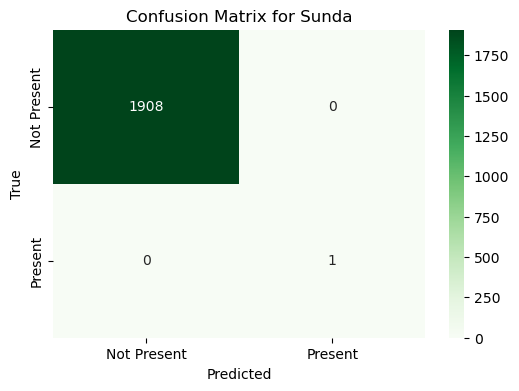

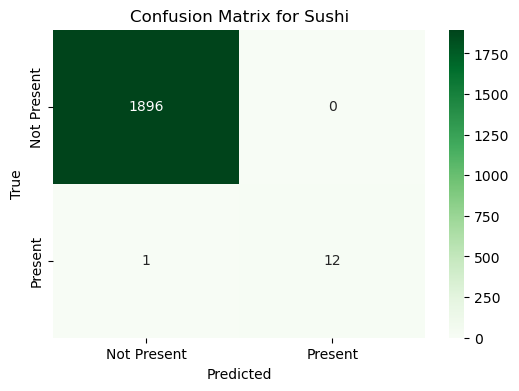

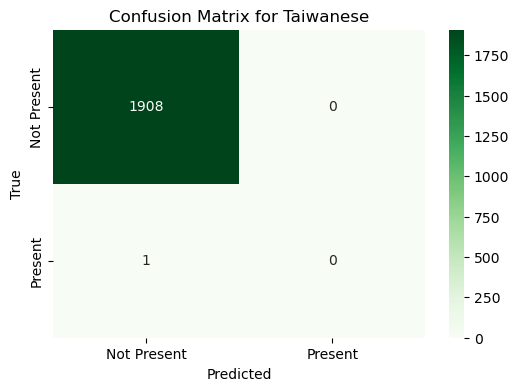

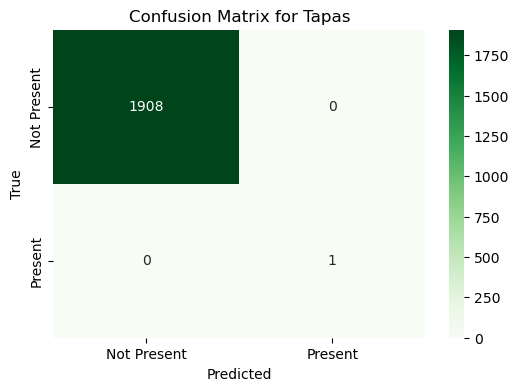

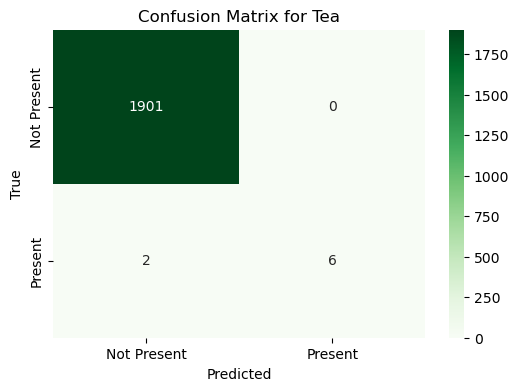

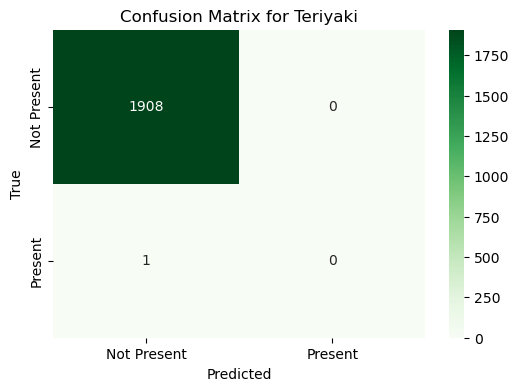

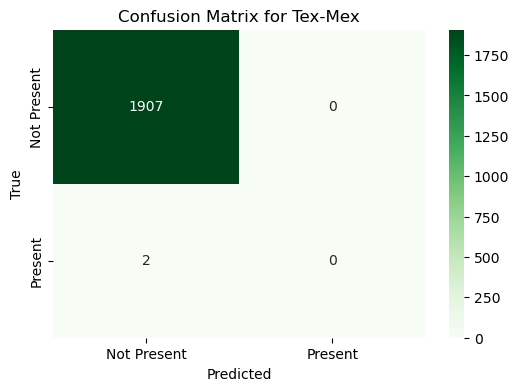

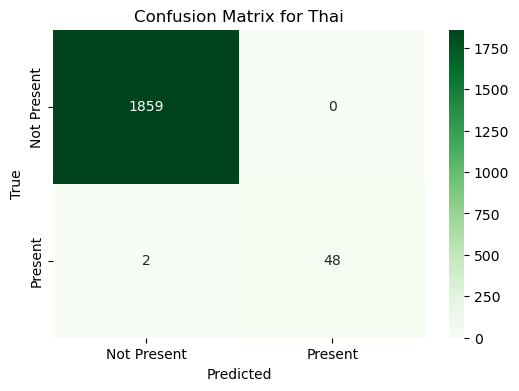

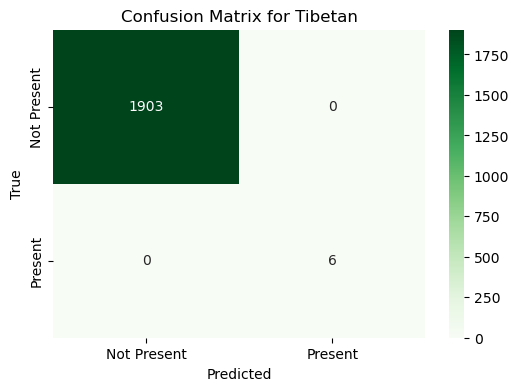

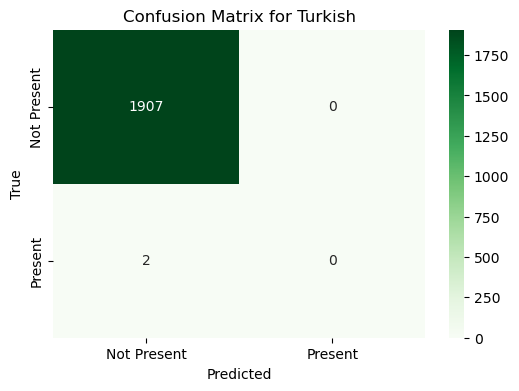

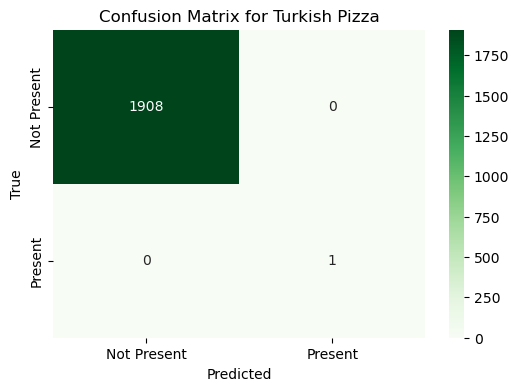

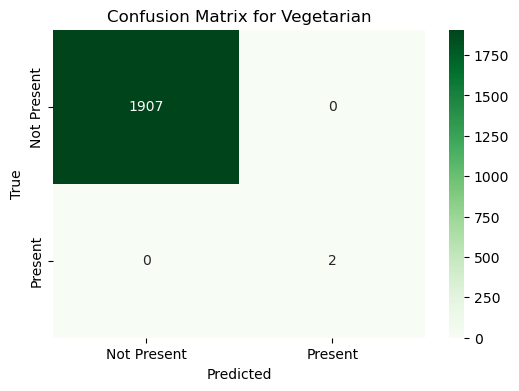

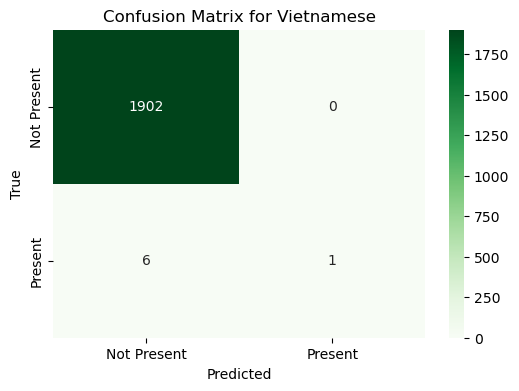

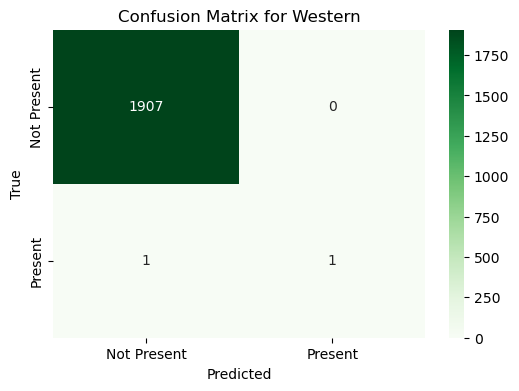

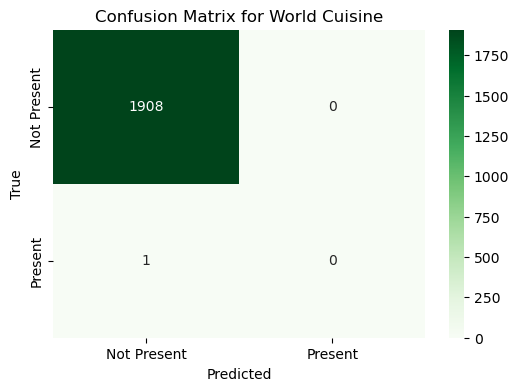

In [164]:
# New matrix without worning
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define all known labels
all_labels = mlb.classes_

# Generate confusion matrix for each cuisine
for i, cuisine in enumerate(all_labels):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred_bal[:, i], labels=[0, 1])  # Specify labels as [0, 1]
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Present', 'Present'], yticklabels=['Not Present', 'Present'])
    plt.title(f'Confusion Matrix for {cuisine}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

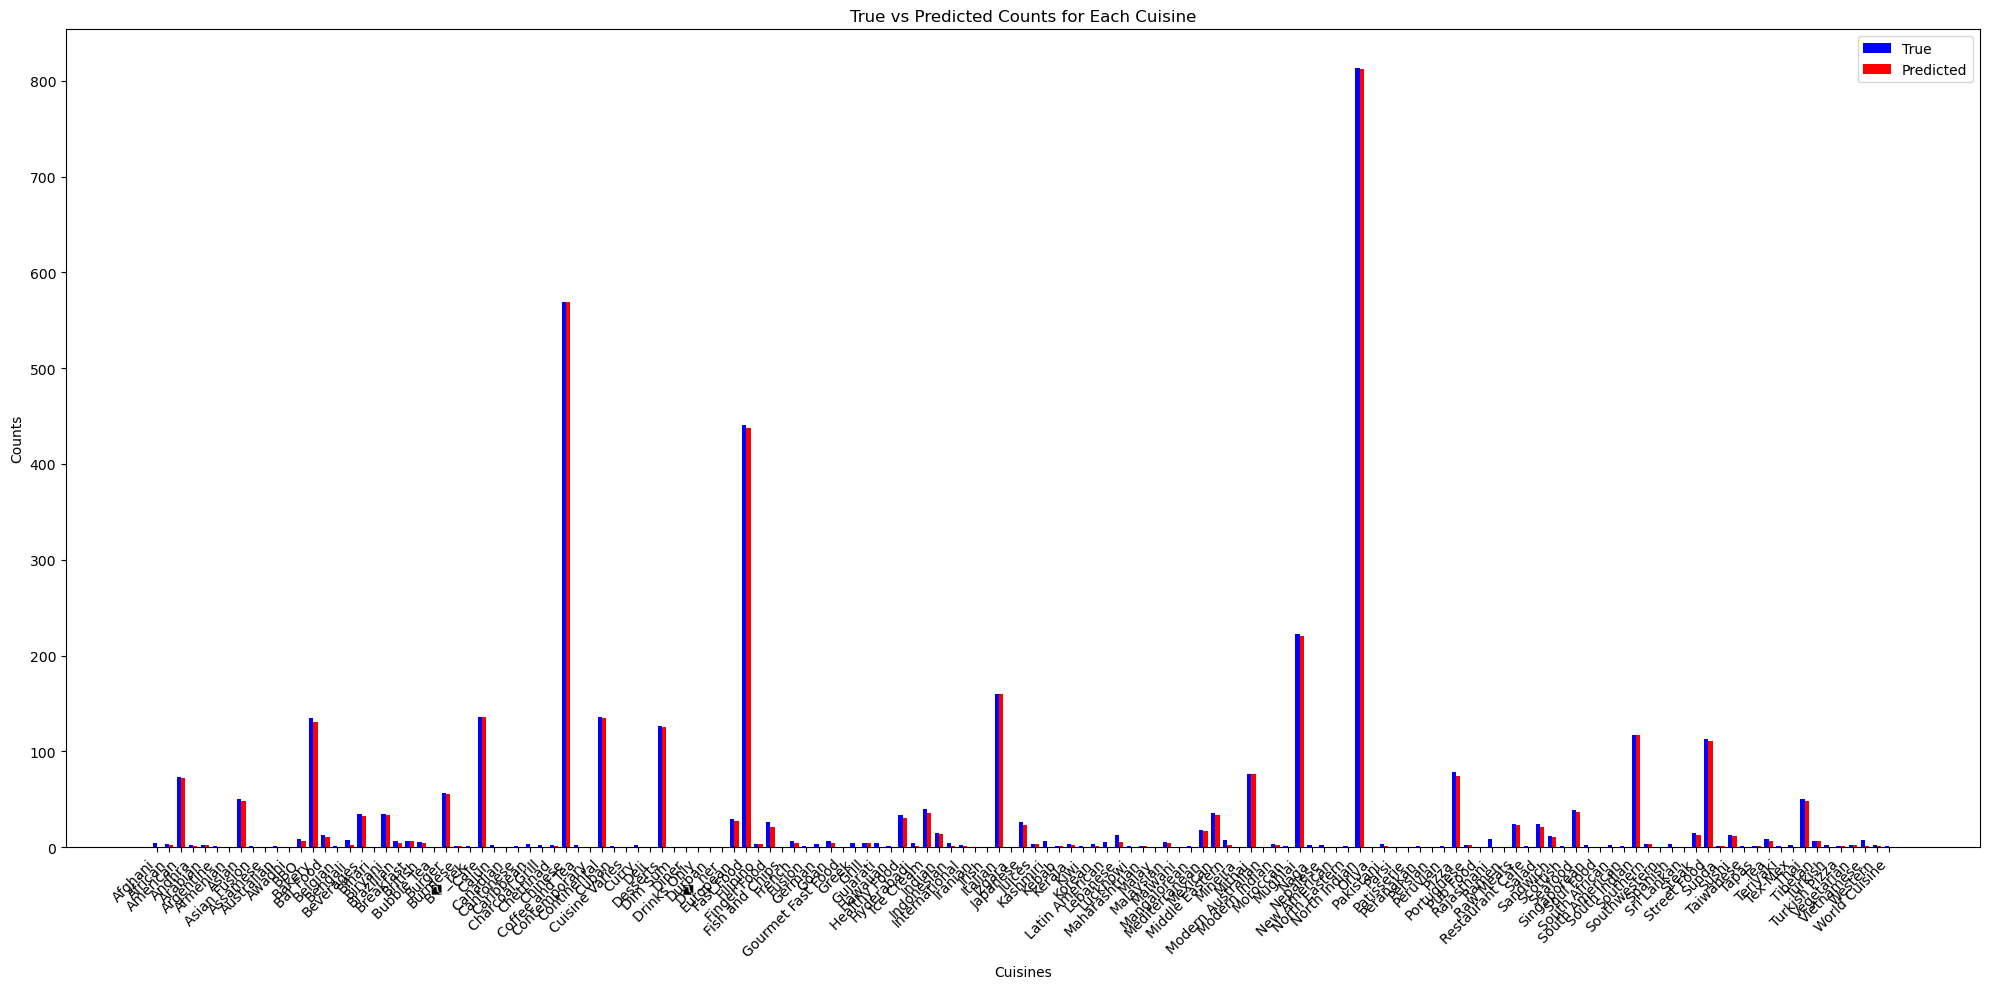

In [151]:
# Plotting the predicted counts with Real counts
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a DataFrame from predictions
prediction_df = pd.DataFrame(y_pred_bal, columns=mlb.classes_)

# Sum up true and predicted values for each cuisine
true_counts = y_test.sum()
predicted_counts = prediction_df.sum()

# Plot the results
plt.figure(figsize=(20, 10))  # Increase the figure size
index = np.arange(len(mlb.classes_))
bar_width = 0.35

plt.bar(index, true_counts, bar_width, label='True', color='b')
plt.bar(index + bar_width, predicted_counts, bar_width, label='Predicted', color='r')

plt.xlabel('Cuisines')
plt.ylabel('Counts')
plt.title('True vs Predicted Counts for Each Cuisine')
plt.xticks(index + bar_width / 2, mlb.classes_, rotation=45, ha='right')  # Rotate and align labels
plt.legend()
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

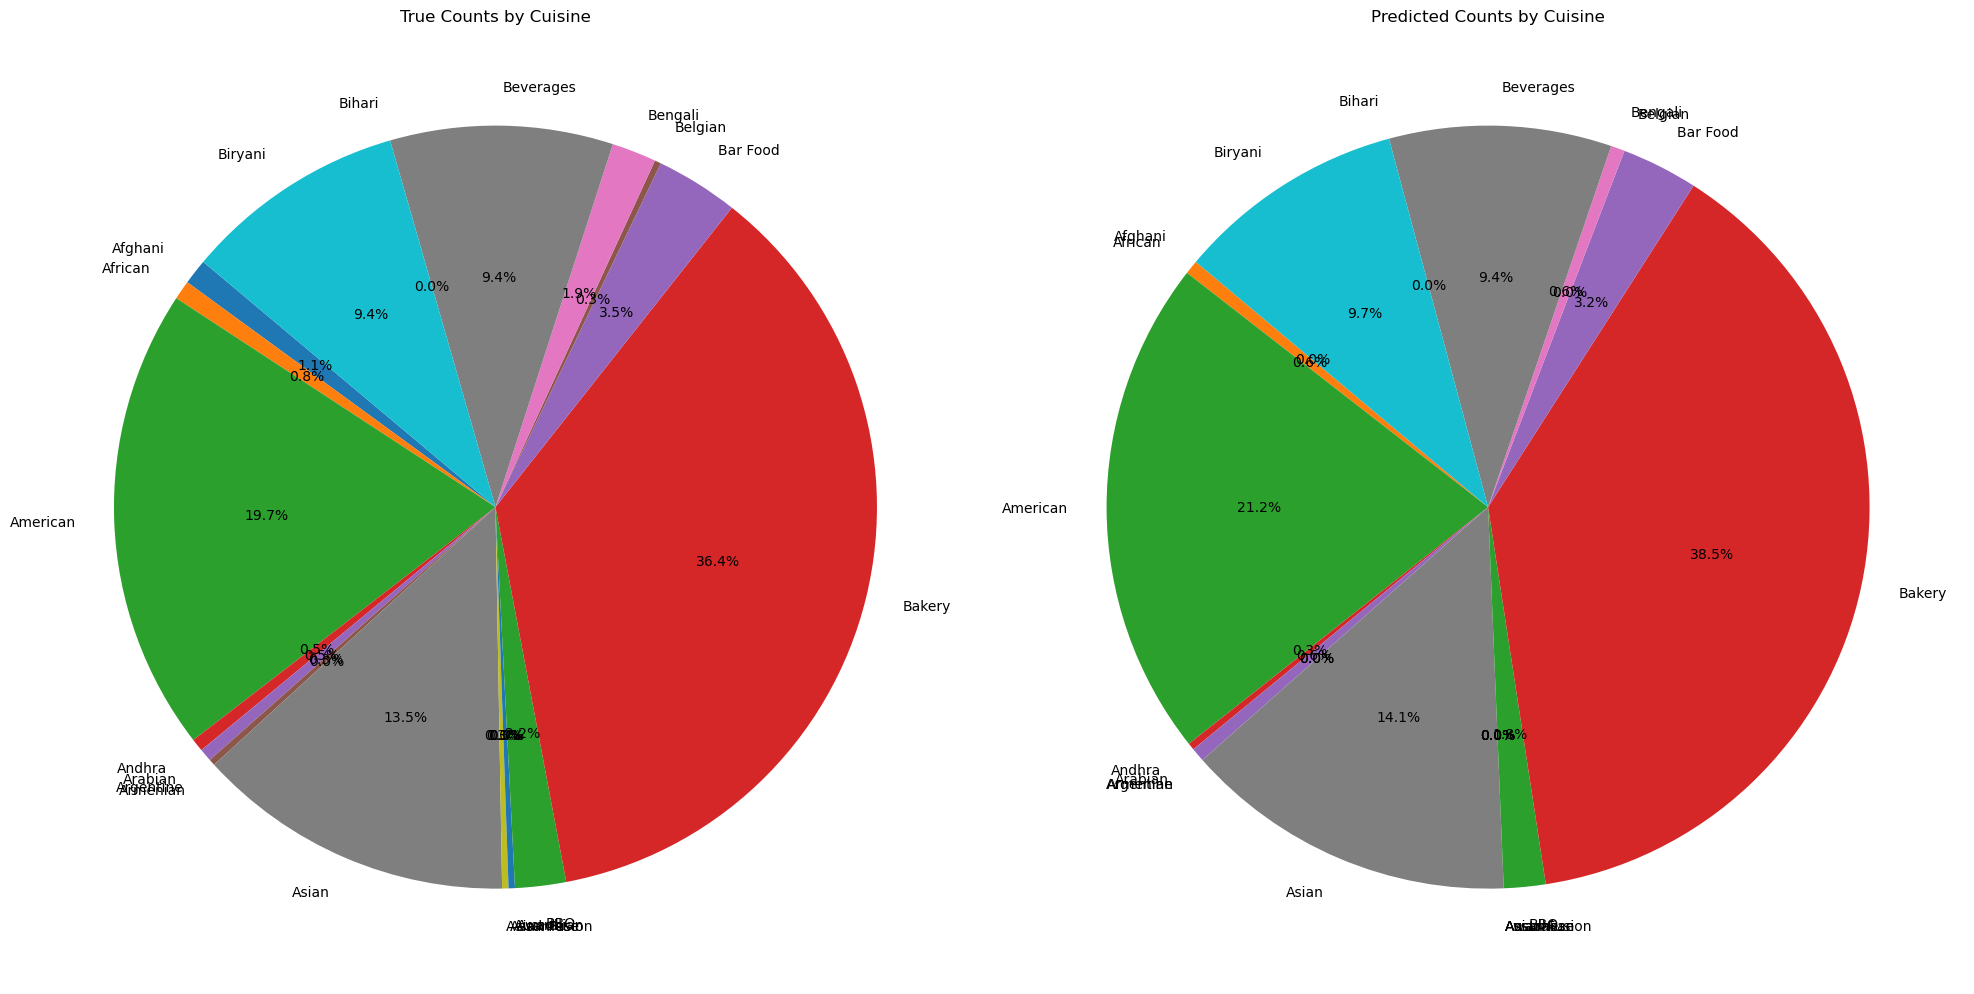

In [157]:
# Few classes for a pie chart to plot True counts vs Predicted counts

top_classes = mlb.classes_[:20]  # Adjust as needed
top_true_counts = true_counts[:20]
top_predicted_counts = predicted_counts[:20]

# Create pie charts
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.pie(top_true_counts, labels=top_classes, autopct='%1.1f%%', startangle=140)
plt.title('True Counts by Cuisine')

plt.subplot(1, 2, 2)
plt.pie(top_predicted_counts, labels=top_classes, autopct='%1.1f%%', startangle=140)
plt.title('Predicted Counts by Cuisine')

plt.tight_layout()
plt.show()

In [166]:
# Counts out of the graph
print(f"Predicted counts are:\n{predicted_counts}")
print(f"\nReal counts are:\n{true_counts}")

Predicted counts are:
Afghani           0
African           2
American         72
Andhra            1
Arabian           2
                 ..
Turkish Pizza     1
Vegetarian        2
Vietnamese        1
Western           1
World Cuisine     0
Length: 145, dtype: int64

Real counts are:
Afghani           4
African           3
American         73
Andhra            2
Arabian           2
                 ..
Turkish Pizza     1
Vegetarian        2
Vietnamese        7
Western           2
World Cuisine     1
Length: 145, dtype: int64


### General Observations
1. Class Imbalance: Some classes, like Afghani and World Cuisine, have very low performance metrics, indicating that the model struggles with these cuisines, possibly due to their rare occurrence in the dataset.
2. High Performance Classes like American and Bakery show very high precision and recall, meaning the model is effective at identifying these cuisines.
3. Future actionable Insights: I will consider strategies for improving performance on underrepresented classes, such as data augmentation or class weighting.
   
The classification report provides valuable insights into the model's performance across various cuisines. It highlights strengths in certain areas and weaknesses in others, particularly with rare classes. Addressing these weaknesses can lead to improved overall accuracy and reliability of the model.